# Seleção de features para criar dataframes ativo e inativo

O objetivo desse notebook é servir de base para analise de quais features são essenciais para definir quais usuários são ativos e quais são inativos.

Uma vez estabelecido esses critérios, ele poderá gerar um script para criar os dataframes de usuários ativos e inativos. Esses dataframes serão usados para a continuidade do processo de seleção e extração de features para posteriormente serem usados nas modelagens de cluster e churn.

No total vão ser 4 dataframes, 2 para usuários ativos e 2 para usuários inativos.
* inactiveUsersLatest.csv
* inactiveEvents_per_UsersLatest.csv
* activeUsersLatest.csv
* activeEvents_per_UsersLatest.csv

Os dataframes relacionados a usuários ativos serão usados para a modelagem de clusters e para a modelagem de churn.

Os dataframes relacionados a usuários inativos serão usados para a modelagem de churn.

Há bem mais usuários inativos do que usuários ativos. Assim para manter um balanceamento o mais próximo possível, foram selecioandas amostras de usuários dos mesmo cohorts que os usuários ativos. O intuito é que essa abordagem poderá ajudar na modelagem de churn.

Os dataframes de eventos (*xxxxxEvents_per_UsersLatest.csv*) se mantiveram os mesmos, foram apenas recortados para manterem eventos referentes aos usuários ativos ou inativos, conforme o caso.

Os dataframes de usuário foram extraídas as seguintes features:

* **firstAccess** - primeira data com evento registrado para o userId
* **lastAcess** - última data com evento registrado para o UserId
* **lasrDayAccess** - quantos dias o usuário acessou a plataforma pela última vez. A conta considera a data do último evento registrado menos a última data de acesso (lastAccess)
* **cohort** - usando o firstAccess, define um cohort para o usuário com base no ano-mês de entrada
* **donationLastXXDays** - usando o lastAccess são criadas features com a quantidade de dias em que o usuário acessou o app e fez um evento de doação em um determinado período. Será criado inicialmente duas columas. Uma para os últimos 120 dias e outra para os últimas 90 dias. Usaremos para fazer a definição de período ativo do usuário.
* **donationLastXXLabel** - usando o donationLastXXDays foram criados labels para fazer uma analise categórica desse campo. Os labels foram de acordo com a quantidade de doação, são eles: 1 dia ativo fazendo doação (Doou1), 2 dias ativos fazendo doação (Doou2), 3 dias ativos fazendo doação (Doou3), 3 a 8 dias ativos fazendo doações (Doou38), mais de 8 dias ativos fazendo doações. Nesse caso foram analisados dois períodos, 90 e 120 dias, assim temos duas colunas com labels.

Ainda para realizar uma analise de retenção é criado neste notebook um dataframe onde se agrupa os usuários de acordo com o mês em que realizaram atividades. Assim é apresentado alguns gráficos como: usuários únicos mensais em contraste com o tempo em que ele está na plataforma ou o mês em que ele entrou na plataforma (cohort).

### Iniciando as biblioteca

In [1]:
# importando os modulos principais

%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path

#from datetime import date, datetime
import matplotlib.pyplot as plt
#import os
import seaborn as sns
#import re
sns.set()

In [2]:
# Define as variáveis com o Path e os nomes dos arquivos atualizados da última extração
data_path = Path('/home/wesley/Github/ribon-parquet')
csv_activeUsers = 'activeUsersLatest.csv'
csv_activeEvents_per_User = 'activeEvents_per_UsersLatest.csv'

In [3]:
%%time
# Carrega dataframe de eventos
events_per_user = pd.read_csv(data_path/csv_activeEvents_per_User, parse_dates=['eventDate'])

# drop colunas que deveria sem excluídas antes de salvar
events_per_user.drop(['Unnamed: 0', 'ativacao', 'activeUser', 'inactiveUser'], axis=1, inplace=True)

# cria uma única coluna de doação sem missing values e drop o evento mais antigo
events_per_user['Doou'] = events_per_user.Doou.fillna(0) + events_per_user.donate.fillna(0)
events_per_user.drop('donate', axis=1, inplace=True)

# index o dataframe pela data
events_per_user.sort_values('eventDate', inplace=True)

# apresenta informações gerais do dataframe
print(events_per_user.shape)
events_per_user.info(),
events_per_user.head()

(1525993, 201)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1525993 entries, 0 to 1525992
Columns: 201 entries, userId to ProfileClickedProfile
dtypes: datetime64[ns](1), float64(199), int64(1)
memory usage: 2.3 GB
CPU times: user 10.7 s, sys: 2.26 s, total: 13 s
Wall time: 13.1 s


userId  uncaught  eventDate  Opened  onBoardingStage  openCurtain  \
0       9       NaN 2017-10-04     1.0              3.0          7.0   
1       2       NaN 2017-10-05     2.0              3.0          5.0   
2       9       NaN 2017-10-05     1.0              NaN          NaN   
3       2       NaN 2017-10-06     2.0              NaN          2.0   
4     193       NaN 2017-10-06     1.0              NaN          6.0   

   changeTabPrincipal  associateWithFacebook  loginAsGuest  loginWithFacebook  \
0                 NaN                    1.0           1.0                NaN   
1                 2.0                    2.0           2.0                NaN   
2                 1.0                    NaN           NaN                NaN   
3                 NaN                    NaN           NaN                NaN   
4                 NaN                    2.0           3.0                NaN   

   ...  PromotionsClickedActiveIcon  PromotionsClickedCTA  \
0  ...                          NaN                   NaN   
1  ...                          NaN                   NaN   
2  ...                          NaN                   NaN   
3  ...                          NaN                   NaN   
4  ...                          NaN                   NaN   

   PromotionsClickedInactiveIcon  PromotionsSawEmptyScreen  \
0                            NaN                       NaN   
1                            NaN                       NaN   
2                            NaN                       NaN   
3                            NaN                       NaN   
4                            NaN                       NaN   

   PromotionsClickedSocial  PromotionsSawPromoCard  \
0                      NaN                     NaN   
1                      NaN                     NaN   
2                      NaN                     NaN   
3                      NaN                     NaN   
4                      NaN                     NaN   

   DonationSawSubscriptionPackage  ImpactSawCommunityImpact  \
0                             NaN                       NaN   
1                             NaN                       NaN   
2                             NaN                       NaN   
3                             NaN                       NaN   
4                             NaN                       NaN   

   ImpactSawUserImpact  ProfileClickedProfile  
0                  NaN                    NaN  
1                  NaN                    NaN  
2                  NaN                    NaN  
3                  NaN                    NaN  
4                  NaN                    NaN  

[5 rows x 201 columns]

In [4]:
# Carrega dataframe de users
users = pd.read_csv(data_path/csv_activeUsers, parse_dates=['firstAccess', 'lastAccess'])

# dropa colunas que deveriam ser removidas antes de salvar
users.drop(['Unnamed: 0', 'donationLast120days', 'donationLast120Label'], axis=1, inplace=True)

# apresenta informações básicas sobre o dataframe
print(users.shape)
users.info(),
users.head()

(22281, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22281 entries, 0 to 22280
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   userId               22281 non-null  int64         
 1   deviceModel          22281 non-null  object        
 2   countryISO           22281 non-null  object        
 3   firstAccess          22281 non-null  datetime64[ns]
 4   lastAccess           22281 non-null  datetime64[ns]
 5   cohort               22281 non-null  object        
 6   donationLast90days   22281 non-null  float64       
 7   lastDayAccess        22281 non-null  int64         
 8   lastDayLabel         22281 non-null  object        
 9   donationLast90Label  22281 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 1.7+ MB


userId       deviceModel countryISO firstAccess lastAccess   cohort  \
0       1  Moto G (5S) Plus         BR  2017-11-07 2020-04-15  2017-11   
1       8        Galaxy S10         BR  2017-10-11 2020-04-15  2017-10   
2       9         Galaxy S8         BR  2017-10-04 2020-04-15  2017-10   
3      23         iPhone XR         BR  2017-10-17 2020-04-14  2017-10   
4      34         moto g(6)         BR  2017-10-11 2020-04-15  2017-10   

   donationLast90days  lastDayAccess lastDayLabel donationLast90Label  
0                14.0              1   Last30Days           DoouMais8  
1                 4.0              1   Last30Days             Doou3_8  
2                12.0              1   Last30Days           DoouMais8  
3                17.0              2   Last30Days           DoouMais8  
4                15.0              1   Last30Days           DoouMais8

In [5]:
# Validando se está igual o número de usuários no dataframe de eventos e o de usuários
events_per_user.userId.nunique() == users.shape[0], events_per_user.userId.nunique(), users.shape[0]

(True, 22281, 22281)

In [6]:
# definindo duas matrizes uma com as colunas que são de eventos e a outra que não são
NO_EVENTS = ['userId', 'eventDate']
EVENTS = [c for c in events_per_user.columns if c not in NO_EVENTS]
len(EVENTS)

199

In [7]:
events_per_user[['Doou']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1525993 entries, 0 to 1525992
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Doou    1525993 non-null  float64
dtypes: float64(1)
memory usage: 23.3 MB


## Criando novas features para o dataframe de usuários

In [8]:
# Criando as funções do histórico completo do usuário

# calcula o número de dias entre o primeiro e último acesso do usuário
def funcCalendarDays(u):
    calendarDays = u['lastAccess'] - u['firstAccess'] + pd.DateOffset(1)
    return calendarDays.days

# encontra o número de dias que o usuário realizou algum evento no app
def funcActiveDays(u):
    return events_per_user[events_per_user.userId == u['userId']].shape[0]

# encontra a meia-vida dos dias ativos
# o número de dias calendários em que o usuário acessou a metade de seus dias ativos
def funcHalfLifeActivityDays(u):
    if u['activeDaysTWT'] % 2 == 0:
        halfLifeActivityDays = int(u['activeDaysTWT'] / 2) - 1
    else:
        halfLifeActivityDays = int(u['activeDaysTWT'] / 2)
    halfLifeActivityDays = list(events_per_user[events_per_user.userId == u['userId']]['eventDate'].sort_values())[halfLifeActivityDays]
    #halfLifeActivityDays = events_per_user[events_per_user.userId == u['userId']]['eventDate'].reindex().iloc[halfLifeActivityDays]
    halfLifeActivityDays = halfLifeActivityDays - u['firstAccess'] + pd.DateOffset(1)
    return halfLifeActivityDays.days

# calcula o número de eventos de doação realizados pelo usuário
def funcDonationTotal(u):
    return events_per_user[events_per_user.userId == u['userId']]['Doou'].sum()

# calcula a meia-vida dos eventos de doação
# pega o número de dias calendários decorridos até o tempo em que o usuário fez metade dos eventos de doação
def funcHalfLifeDonation(u):        
    if (u['calendarDays'] > 0) & (u['donationTWT'] > 0):
        cont = 0
        limite = int(u['donationTWT']/2)
        soma = 0
        for d in events_per_user.loc[events_per_user.userId == u['userId'], 'Doou']:
            soma += d
            if soma > limite:
                break
            cont += 1
        halfLifeDonation = events_per_user[events_per_user.userId == u['userId']]['eventDate'].reindex().iloc[cont]
        halfLifeDonation = halfLifeDonation - u['firstAccess'] + pd.DateOffset(1)
        return halfLifeDonation.days
    else:
        return 0

In [9]:
# Aplica as funções para criar as features número de dias calendário, dias ativos e meia vida de dias ativos

# calendarDays - calcula o número de dias calendários na plataforma
%time users['calendarDays'] = users.apply(funcCalendarDays, axis=1)

# activeDays - calcula o número de dias ativos
%time users['activeDaysTWT'] = users.apply(funcActiveDays, axis=1)

# média de dias ativos
%time users['averageActiveDaysTWT'] = users['activeDaysTWT'] / users['calendarDays']

# halfLifeActivityDays - calcula o meia-vida de dias ativos
%time users['halfLifeActivityDaysTWT'] = users.apply(funcHalfLifeActivityDays, axis=1)

# donationTotal - calcula o total de eventos de doação por usuário
%time users['donationTWT'] = users.apply(funcDonationTotal, axis=1)

# halfLifeDonation - calcula a meia-vida de doações
%time users['halfLifeDonationTWT'] = users.apply(funcHalfLifeDonation, axis=1)

CPU times: user 1.79 s, sys: 3.45 ms, total: 1.79 s
Wall time: 1.79 s
CPU times: user 53.3 s, sys: 110 µs, total: 53.3 s
Wall time: 53.3 s
CPU times: user 906 µs, sys: 33 µs, total: 939 µs
Wall time: 798 µs
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s
CPU times: user 52.7 s, sys: 11.4 ms, total: 52.7 s
Wall time: 52.7 s
CPU times: user 1min 37s, sys: 3.82 ms, total: 1min 37s
Wall time: 1min 37s


In [10]:
users.head()

userId       deviceModel countryISO firstAccess lastAccess   cohort  \
0       1  Moto G (5S) Plus         BR  2017-11-07 2020-04-15  2017-11   
1       8        Galaxy S10         BR  2017-10-11 2020-04-15  2017-10   
2       9         Galaxy S8         BR  2017-10-04 2020-04-15  2017-10   
3      23         iPhone XR         BR  2017-10-17 2020-04-14  2017-10   
4      34         moto g(6)         BR  2017-10-11 2020-04-15  2017-10   

   donationLast90days  lastDayAccess lastDayLabel donationLast90Label  \
0                14.0              1   Last30Days           DoouMais8   
1                 4.0              1   Last30Days             Doou3_8   
2                12.0              1   Last30Days           DoouMais8   
3                17.0              2   Last30Days           DoouMais8   
4                15.0              1   Last30Days           DoouMais8   

   calendarDays  activeDaysTWT  averageActiveDaysTWT  halfLifeActivityDaysTWT  \
0           891             74              0.083053                      766   
1           918             80              0.087146                      294   
2           925            391              0.422703                      364   
3           911            182              0.199780                      570   
4           918            382              0.416122                      630   

   donationTWT  halfLifeDonationTWT  
0        163.0                  823  
1         91.0                  163  
2        302.0                  429  
3        144.0                  559  
4        365.0                  529

Uma vez calculado as features que usam todos os eventos, vamos reduzir o tamanho do dataset de eventos por usuário para manter apenas os eventos do período ativo.

Assim vamos:

1) gerar features para esse período do tempo

2) fazer uma analise sobre a importancia dos eventos

In [11]:
# verificando a data do último evento e definindo a data de corte para definir usuários ativos
days_AP = 90                                                 # define quantos dias é o AP - Active Period
lastDay = events_per_user.eventDate.sort_values().iloc[-1]   # encontra a última data do dataframe de eeventos
beginActivePeriod = lastDay - pd.DateOffset(days=days_AP -1) # define o dia em que inicia o AP
beginActivePeriod

Timestamp('2020-01-18 00:00:00')

In [12]:
events_per_user.shape[0], events_per_user[events_per_user.eventDate >= beginActivePeriod].shape[0]

(1525993, 496385)

In [13]:
events_per_user = events_per_user[events_per_user.eventDate >= beginActivePeriod]

In [14]:
# encontra o número de dias que o usuário realizou algum evento no app durante o AP
def funcActiveDaysAP(u):
    return events_per_user[events_per_user.userId == u['userId']].shape[0]

# identifica a média de dias entre os eventos de doação
# caso o usuário tenha feito um ou nenhum evento de doação, retorno NaN
def funcAverageDaysBetweenDonationEvents(u):
    x = events_per_user[(events_per_user.userId == u['userId']) & (events_per_user.Doou>0)][['eventDate','Doou']]
    if x.shape[0] > 1:
        a = 0
        b = 0
        for i, e in reversed(list(enumerate(x.iterrows()))):
            if a == 0:
                a+= 1
                ultimaData = e[1][0]
                continue
            novaData = e[1][0]
            dif = ultimaData - novaData
            b += dif.days
            ultimaData = novaData
        return b/(x.shape[0]-1)
    else:
        return np.nan

# identifica o número de dias entre o último e o penúltimo acesso
# caso o usuário tenha feito uma ou nenhum evento de doação, retorno NaN
def funcDaysSinceLastDonationEvent(u):
    x = events_per_user[(events_per_user.userId == u['userId']) & (events_per_user.Doou>0)][['eventDate','Doou']]
    if x.shape[0] > 1:
        return (x.reindex().iloc[-1, 0] - x.reindex().iloc[-2, 0]).days
    else:
        return np.nan

In [15]:
# activeDays - calcula o número de dias ativos
%time users['activeDaysAP'] = users.apply(funcActiveDaysAP, axis=1)

# quantidade de doações no período ativo
%time users['donationAP'] = users.apply(funcDonationTotal, axis=1)

# averageEventActiveDay - calcula a média de doações por dias ativos
%time users['averageDonationActiveDayAP'] = users['donationAP'] / users['activeDaysAP']

# averageEventActiveDay - calcula a média de doações no período ativo 
%time users['averageDonationAP'] = users['donationAP'] / days_AP

# Aplica as funções para criar as features relacionadas a doação
# número de doações totais, media de eventos de doação por dias ativos, media de eventos de doação por dias calendários
# meia-vida dos eventos de doação

# averageDaysBetweenDonationEvents - média de dias entre os eventos de doação
%time users['averageDaysBetweenDonationEvents'] = users.apply(funcAverageDaysBetweenDonationEvents, axis=1)

# daysSinceLastDonationEvent - número de dias entre a última e penultima doação
%time users['daysSinceLastDonations'] = users.apply(funcDaysSinceLastDonationEvent, axis=1)

CPU times: user 21.8 s, sys: 3.97 ms, total: 21.8 s
Wall time: 21.8 s
CPU times: user 24.8 s, sys: 7.96 ms, total: 24.8 s
Wall time: 24.8 s
CPU times: user 866 µs, sys: 6 µs, total: 872 µs
Wall time: 740 µs
CPU times: user 733 µs, sys: 6 µs, total: 739 µs
Wall time: 613 µs
CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s
CPU times: user 1min 1s, sys: 8.02 ms, total: 1min 1s
Wall time: 1min 1s


In [16]:
users.head()

userId       deviceModel countryISO firstAccess lastAccess   cohort  \
0       1  Moto G (5S) Plus         BR  2017-11-07 2020-04-15  2017-11   
1       8        Galaxy S10         BR  2017-10-11 2020-04-15  2017-10   
2       9         Galaxy S8         BR  2017-10-04 2020-04-15  2017-10   
3      23         iPhone XR         BR  2017-10-17 2020-04-14  2017-10   
4      34         moto g(6)         BR  2017-10-11 2020-04-15  2017-10   

   donationLast90days  lastDayAccess lastDayLabel donationLast90Label  ...  \
0                14.0              1   Last30Days           DoouMais8  ...   
1                 4.0              1   Last30Days             Doou3_8  ...   
2                12.0              1   Last30Days           DoouMais8  ...   
3                17.0              2   Last30Days           DoouMais8  ...   
4                15.0              1   Last30Days           DoouMais8  ...   

   averageActiveDaysTWT  halfLifeActivityDaysTWT  donationTWT  \
0              0.083053                      766        163.0   
1              0.087146                      294         91.0   
2              0.422703                      364        302.0   
3              0.199780                      570        144.0   
4              0.416122                      630        365.0   

   halfLifeDonationTWT  activeDaysAP  donationAP  averageDonationActiveDayAP  \
0                  823            27        98.0                    3.629630   
1                  163             6         9.0                    1.500000   
2                  429            31        26.0                    0.838710   
3                  559            30        20.0                    0.666667   
4                  529            66        22.0                    0.333333   

   averageDonationAP  averageDaysBetweenDonationEvents  daysSinceLastDonations  
0           1.088889                          6.692308                       1  
1           0.100000                         23.666667                      15  
2           0.288889                          7.636364                       7  
3           0.222222                          4.750000                      14  
4           0.244444                          3.642857                       4  

[5 rows x 22 columns]

In [17]:
users.describe().T

count           mean           std  \
userId                            22281.0  179279.227728  76844.795477   
donationLast90days                22281.0      11.321530     13.912229   
lastDayAccess                     22281.0      15.773484     21.127116   
calendarDays                      22281.0     180.772631    164.238781   
activeDaysTWT                     22281.0      68.488533     85.229088   
averageActiveDaysTWT              22281.0       0.417770      0.270318   
halfLifeActivityDaysTWT           22281.0      79.222611     89.436246   
donationTWT                       22281.0      97.296037    134.999252   
halfLifeDonationTWT               22281.0      77.003591     89.354376   
activeDaysAP                      22281.0      22.278399     22.675308   
donationAP                        22281.0      35.381895     50.575854   
averageDonationActiveDayAP        22281.0       2.355371      2.348698   
averageDonationAP                 22281.0       0.393132      0.561954   
averageDaysBetweenDonationEvents  22281.0       9.128594     10.795093   
daysSinceLastDonations            22281.0      10.560029     12.730750   

                                       min            25%            50%  \
userId                            1.000000  128218.000000  205874.000000   
donationLast90days                2.000000       3.000000       6.000000   
lastDayAccess                     0.000000       0.000000       4.000000   
calendarDays                      2.000000      38.000000     138.000000   
activeDaysTWT                     2.000000       8.000000      32.000000   
averageActiveDaysTWT              0.008547       0.181818       0.375000   
halfLifeActivityDaysTWT           1.000000      12.000000      54.000000   
donationTWT                       2.000000      17.000000      47.000000   
halfLifeDonationTWT               1.000000      11.000000      50.000000   
activeDaysAP                      2.000000       5.000000      12.000000   
donationAP                        2.000000       9.000000      18.000000   
averageDonationActiveDayAP        0.025000       0.833333       1.641509   
averageDonationAP                 0.022222       0.100000       0.200000   
averageDaysBetweenDonationEvents  1.000000       2.500000       5.250000   
daysSinceLastDonations            1.000000       2.000000       6.000000   

                                            75%            max  
userId                            244158.000000  267866.000000  
donationLast90days                    13.000000      90.000000  
lastDayAccess                         25.000000      88.000000  
calendarDays                         306.000000     925.000000  
activeDaysTWT                         99.000000     724.000000  
averageActiveDaysTWT                   0.625000       1.000000  
halfLifeActivityDaysTWT              115.000000     779.000000  
donationTWT                          121.000000    2142.000000  
halfLifeDonationTWT                  110.000000     877.000000  
activeDaysAP                          35.000000      90.000000  
donationAP                            42.000000    2075.000000  
averageDonationActiveDayAP             3.125000      61.000000  
averageDonationAP                      0.466667      23.055556  
averageDaysBetweenDonationEvents      11.400000      88.000000  
daysSinceLastDonations                14.000000      88.000000

In [20]:
users[users.donationAP > 500]

userId                 deviceModel countryISO firstAccess lastAccess  \
54       1869       Moto G Plus (5th Gen)         BR  2019-08-17 2020-04-15   
207      6944                   Redmi K20         BR  2018-05-20 2020-04-16   
763     30764         motorola one action         BR  2019-01-16 2020-04-16   
952     38490                   Galaxy S9         BR  2019-02-05 2020-04-16   
1019    40661             Galaxy J5 Prime         BR  2019-02-14 2020-04-15   
1095    44039          ZenFone4 (ZE554KL)         BR  2019-03-07 2020-04-16   
1645    61408                     LG K40S         BR  2019-04-21 2020-04-16   
2743   112196            Xperia XA1 Ultra         BR  2019-05-05 2020-04-16   
2922   122080                  ASUS_X00TD         BR  2019-05-12 2020-04-16   
3710   143486  ZenFone 4 Selfie (ZD553KL)         BR  2019-06-25 2020-04-16   
3949   149917                   Galaxy J8         BR  2019-07-14 2020-04-16   
5304   187550                  ASUS_X00TD         BR  2019-10-17 2020-04-16   
5504   193343                  Galaxy A50         BR  2019-10-23 2020-04-15   
5589   194585            Galaxy A7 (2018)         BR  2019-10-25 2020-04-16   
5764   197420                     VIBE K6         BR  2019-10-26 2020-04-16   
6733   218946             Galaxy A7(2017)         BR  2019-12-03 2020-04-16   
7062   226857                 Moto G (5S)         BR  2019-12-15 2020-04-16   
7461   235582                       Mi A3         BR  2020-01-14 2020-04-16   
17580  243679                   Galaxy S6         BR  2020-02-11 2020-04-09   

        cohort  donationLast90days  lastDayAccess lastDayLabel  \
54     2019-08                34.0              1   Last30Days   
207    2018-05                63.0              0   Last30Days   
763    2019-01                19.0              0   Last30Days   
952    2019-02                16.0              0   Last30Days   
1019   2019-02                58.0              1   Last30Days   
1095   2019-03                53.0              0   Last30Days   
1645   2019-04                88.0              0   Last30Days   
2743   2019-05                79.0              0   Last30Days   
2922   2019-05                15.0              0   Last30Days   
3710   2019-06                17.0              0   Last30Days   
3949   2019-07                88.0              0   Last30Days   
5304   2019-10                56.0              0   Last30Days   
5504   2019-10                37.0              1   Last30Days   
5589   2019-10                63.0              0   Last30Days   
5764   2019-10                21.0              0   Last30Days   
6733   2019-12                50.0              0   Last30Days   
7062   2019-12                47.0              0   Last30Days   
7461   2020-01                41.0              0   Last30Days   
17580  2020-02                 8.0              7   Last30Days   

      donationLast90Label  ...  averageActiveDaysTWT  halfLifeActivityDaysTWT  \
54              DoouMais8  ...              0.374486                      192   
207             DoouMais8  ...              0.567335                      315   
763             DoouMais8  ...              0.330416                      366   
952             DoouMais8  ...              0.659039                      220   
1019            DoouMais8  ...              0.817330                      230   
1095            DoouMais8  ...              0.931204                      199   
1645            DoouMais8  ...              0.441989                      282   
2743            DoouMais8  ...              0.951149                      176   
2922            DoouMais8  ...              0.709677                      137   
3710            DoouMais8  ...              0.676768                      119   
3949            DoouMais8  ...              0.615108                      193   
5304            DoouMais8  ...              0.857923                      102   
5504            DoouMais8  ...              0.738636

### Criando features categóricas com os dados extraídos

Não será usado no modelo mas na analise visual dos dados

#### calendar days

In [21]:
users.describe().T

count           mean           std  \
userId                            22281.0  179279.227728  76844.795477   
donationLast90days                22281.0      11.321530     13.912229   
lastDayAccess                     22281.0      15.773484     21.127116   
calendarDays                      22281.0     180.772631    164.238781   
activeDaysTWT                     22281.0      68.488533     85.229088   
averageActiveDaysTWT              22281.0       0.417770      0.270318   
halfLifeActivityDaysTWT           22281.0      79.222611     89.436246   
donationTWT                       22281.0      97.296037    134.999252   
halfLifeDonationTWT               22281.0      77.003591     89.354376   
activeDaysAP                      22281.0      22.278399     22.675308   
donationAP                        22281.0      35.381895     50.575854   
averageDonationActiveDayAP        22281.0       2.355371      2.348698   
averageDonationAP                 22281.0       0.393132      0.561954   
averageDaysBetweenDonationEvents  22281.0       9.128594     10.795093   
daysSinceLastDonations            22281.0      10.560029     12.730750   

                                       min            25%            50%  \
userId                            1.000000  128218.000000  205874.000000   
donationLast90days                2.000000       3.000000       6.000000   
lastDayAccess                     0.000000       0.000000       4.000000   
calendarDays                      2.000000      38.000000     138.000000   
activeDaysTWT                     2.000000       8.000000      32.000000   
averageActiveDaysTWT              0.008547       0.181818       0.375000   
halfLifeActivityDaysTWT           1.000000      12.000000      54.000000   
donationTWT                       2.000000      17.000000      47.000000   
halfLifeDonationTWT               1.000000      11.000000      50.000000   
activeDaysAP                      2.000000       5.000000      12.000000   
donationAP                        2.000000       9.000000      18.000000   
averageDonationActiveDayAP        0.025000       0.833333       1.641509   
averageDonationAP                 0.022222       0.100000       0.200000   
averageDaysBetweenDonationEvents  1.000000       2.500000       5.250000   
daysSinceLastDonations            1.000000       2.000000       6.000000   

                                            75%            max  
userId                            244158.000000  267866.000000  
donationLast90days                    13.000000      90.000000  
lastDayAccess                         25.000000      88.000000  
calendarDays                         306.000000     925.000000  
activeDaysTWT                         99.000000     724.000000  
averageActiveDaysTWT                   0.625000       1.000000  
halfLifeActivityDaysTWT              115.000000     779.000000  
donationTWT                          121.000000    2142.000000  
halfLifeDonationTWT                  110.000000     877.000000  
activeDaysAP                          35.000000      90.000000  
donationAP                            42.000000    2075.000000  
averageDonationActiveDayAP             3.125000      61.000000  
averageDonationAP                      0.466667      23.055556  
averageDaysBetweenDonationEvents      11.400000      88.000000  
daysSinceLastDonations                14.000000      88.000000

In [22]:
percentiles = [10, 25, 50, 75, 90]

In [23]:
# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(users.calendarDays, percentiles)
ptiles_vers

array([ 10.,  38., 138., 306., 372.])

In [24]:
# criando colunas categóricas para fazer a analise
users['calendarDaysLabel'] = pd.cut(users.calendarDays,bins=[0,35,65,125,185,370,9999],
                             labels=['ThisMonth','LastMonth', 'ThisQuarter','ThisSemester', 'ThisYear','Older'])

In [25]:
users[['calendarDays', 'calendarDaysLabel']].sample(10)

calendarDays calendarDaysLabel
4128            266          ThisYear
10946           517             Older
19560            18         ThisMonth
9689             16         ThisMonth
17615            56         LastMonth
18194            22         ThisMonth
9223             24         ThisMonth
15419           130      ThisSemester
11067           445             Older
19316            34         ThisMonth

In [26]:
# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(users.donationAP, percentiles)
ptiles_vers

array([ 5.,  9., 18., 42., 87.])

In [27]:
# criando colunas categóricas para fazer a analise
users['donationAPLabel'] = pd.cut(users.donationAP,bins=[0,2,9,18,42,87,9999],
                                 labels=['Minimo','Pouco', 'Regular','AcimaMedia', 'Muito', 'Insano'])

In [28]:
users[['donationAP', 'donationAPLabel']].sample(10)

donationAP donationAPLabel
8890          6.0           Pouco
21029         5.0           Pouco
1482        110.0          Insano
10278        13.0         Regular
15104       111.0          Insano
8692         52.0           Muito
13978         5.0           Pouco
1178          8.0           Pouco
9454         17.0         Regular
14527         5.0           Pouco

In [29]:
users.describe(exclude='number')

deviceModel countryISO          firstAccess           lastAccess  \
count        22281      22281                22281                22281   
unique         507         52                  772                   89   
top       iPhone 7         BR  2019-05-01 00:00:00  2020-04-16 00:00:00   
freq          1579      21333                  662                 5612   
first          NaN        NaN  2017-10-04 00:00:00  2020-01-19 00:00:00   
last           NaN        NaN  2020-04-15 00:00:00  2020-04-16 00:00:00   

         cohort lastDayLabel donationLast90Label calendarDaysLabel  \
count     22281        22281               22281             22281   
unique       31            2                   4                 6   
top     2020-02   Last30Days           DoouMais8          ThisYear   
freq       2792        17598                8187              6752   
first       NaN          NaN                 NaN               NaN   
last        NaN          NaN                 NaN               NaN   

       donationAPLabel  
count            22281  
unique               6  
top              Pouco  
freq              5597  
first              NaN  
last               NaN

## Analise dos eventos

In [30]:
df = events_per_user.drop('eventDate', axis=1).groupby('userId').sum()
print(df.shape,
df.head().T)

(22281, 199) userId                           1    2    8    9    15
uncaught                        0.0  3.0  0.0  0.0  0.0
Opened                          0.0  0.0  0.0  0.0  0.0
onBoardingStage                 0.0  0.0  0.0  0.0  0.0
openCurtain                     0.0  0.0  0.0  0.0  0.0
changeTabPrincipal              0.0  0.0  0.0  0.0  0.0
...                             ...  ...  ...  ...  ...
PromotionsSawPromoCard          0.0  0.0  0.0  0.0  0.0
DonationSawSubscriptionPackage  2.0  0.0  0.0  0.0  0.0
ImpactSawCommunityImpact        0.0  0.0  0.0  0.0  0.0
ImpactSawUserImpact             0.0  0.0  0.0  0.0  0.0
ProfileClickedProfile           0.0  0.0  0.0  0.0  0.0

[199 rows x 5 columns]


In [31]:
# Verificando quantas colunas tem valor 0 para o período ativo.
# Essa mascara será usada para reduzir a dimensionalidade do dataframe
(df.sum() > 0).sum()

107

In [32]:
df = df.loc[:,df.sum() > 0]
print(df.shape)
df

(22281, 107)


uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
userId                                                                   
1            0.0          0.0                  0.0                12.0   
2            3.0          0.0                  0.0                 0.0   
8            0.0          0.0                  0.0                 1.0   
9            0.0          0.0                  0.0                 0.0   
15           0.0          0.0                  0.0                 4.0   
...          ...          ...                  ...                 ...   
267789       5.0          0.0                  0.0                 0.0   
267834       1.0          0.0                  0.0                 0.0   
267841       0.0          0.0                  0.0                 0.0   
267856       0.0          0.0                  0.0                 0.0   
267866       3.0          0.0                  0.0                 0.0   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
userId                                                                        
1             0.0                 46.0          0.0                     0.0   
2             0.0                  5.0          2.0                     0.0   
8             0.0                 10.0          0.0                     0.0   
9             0.0                 38.0          0.0                     7.0   
15            0.0                 35.0          0.0                     0.0   
...           ...                  ...          ...                     ...   
267789        0.0                  8.0          1.0                     0.0   
267834        0.0                  4.0          1.0                     0.0   
267841        0.0                  3.0          1.0                     0.0   
267856        0.0                 10.0          1.0                     0.0   
267866        0.0                  6.0          1.0                     0.0   

        OpenedDonationModalFromCard  SawAdBeforeDonate  ...  \
userId                                                  ...   
1                             104.0              249.0  ...   
2                              16.0               44.0  ...   
8                               9.0               25.0  ...   
9                              34.0               81.0  ...   
15                             11.0               29.0  ...   
...                             ...                ...  ...   
267789                         16.0               42.0  ...   
267834                         11.0               22.0  ...   
267841                         14.0               39.0  ...   
267856                         11.0               33.0  ...   
267866                         15.0               35.0  ...   

        PromotionsClickedActiveIcon  PromotionsClickedCTA  \
userId                                                      
1                               1.0                   0.0   
2                               1.0                   0.0   
8                               2.0                   0.0   
9                               7.0                   5.0   
15                              9.0                   2.0   
...                             ...                   ...   
267789                          0.0                   0.0   
267834                          0.0                   0.0   
267841                          0.0                   0.0   
267856                          0.0                   0.0   
267866                          0.0                   0.0   

        PromotionsClickedInactiveIcon  PromotionsSawEmptyScreen  \
userId                                                            
1                                 0.0                       0.0   
2                                 0.0                       0.0   
8                                 0.0                       0.0   
9                                 2.0                       0.0   
1

In [33]:
%%time
from sklearn.manifold import TSNE

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(df)
print(tsne_features.shape)

(22281, 2)
CPU times: user 11min 26s, sys: 10.2 s, total: 11min 37s
Wall time: 1min 59s


In [34]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

In [35]:
df.head()

uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
userId                                                                   
1            0.0          0.0                  0.0                12.0   
2            3.0          0.0                  0.0                 0.0   
8            0.0          0.0                  0.0                 1.0   
9            0.0          0.0                  0.0                 0.0   
15           0.0          0.0                  0.0                 4.0   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
userId                                                                        
1             0.0                 46.0          0.0                     0.0   
2             0.0                  5.0          2.0                     0.0   
8             0.0                 10.0          0.0                     0.0   
9             0.0                 38.0          0.0                     7.0   
15            0.0                 35.0          0.0                     0.0   

        OpenedDonationModalFromCard  SawAdBeforeDonate  ...  \
userId                                                  ...   
1                             104.0              249.0  ...   
2                              16.0               44.0  ...   
8                               9.0               25.0  ...   
9                              34.0               81.0  ...   
15                             11.0               29.0  ...   

        PromotionsClickedInactiveIcon  PromotionsSawEmptyScreen  \
userId                                                            
1                                 0.0                       0.0   
2                                 0.0                       0.0   
8                                 0.0                       0.0   
9                                 2.0                       0.0   
15                                1.0                       0.0   

        PromotionsClickedSocial  PromotionsSawPromoCard  \
userId                                                    
1                           0.0                     0.0   
2                           0.0                     0.0   
8                           0.0                     0.0   
9                           0.0                     0.0   
15                          0.0                     0.0   

        DonationSawSubscriptionPackage  ImpactSawCommunityImpact  \
userId                                                             
1                                  2.0                       0.0   
2                                  0.0                       0.0   
8                                  0.0                       0.0   
9                                  0.0                       0.0   
15                                 0.0                       0.0   

        ImpactSawUserImpact  ProfileClickedProfile          x          y  
userId                                                                    
1                       0.0                    0.0  31.303907 -29.229593  
2                       0.0                    0.0  12.182482  23.747999  
8                       0.0                    0.0   0.053587   9.983828  
9                       0.0                    0.0  21.659500  10.724605  
15                      0.0                    0.0   1.438232   2.371799  

[5 rows x 109 columns]

In [36]:
df1 = users.join(df[['x', 'y']], on='userId')

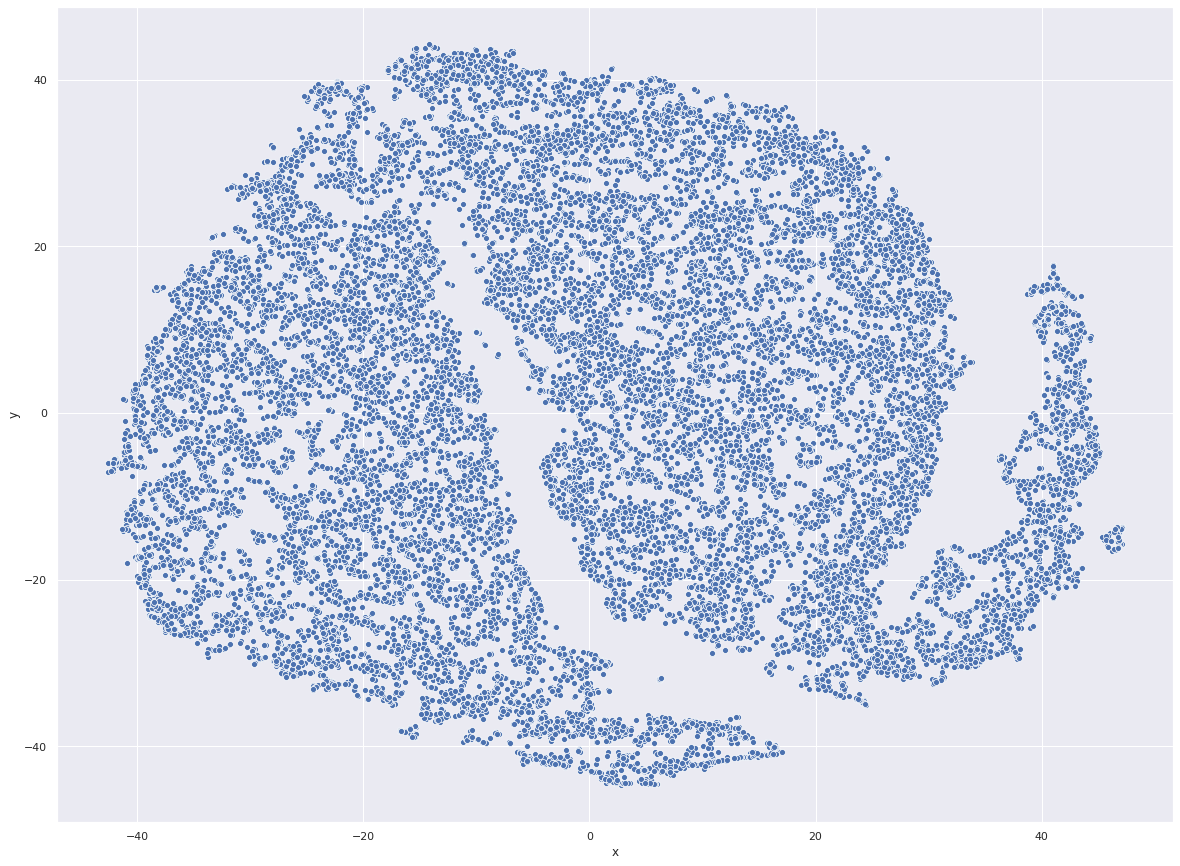

In [37]:
plt.figure(figsize=(20,15))

# No color the points 
sns.scatterplot(x="x", y="y", data=df1)

# Show the plot
plt.show()

In [38]:
[c for c in df1.columns if 'label' in c.lower()] + ['x', 'y']

['lastDayLabel',
 'donationLast90Label',
 'calendarDaysLabel',
 'donationAPLabel',
 'x',
 'y']

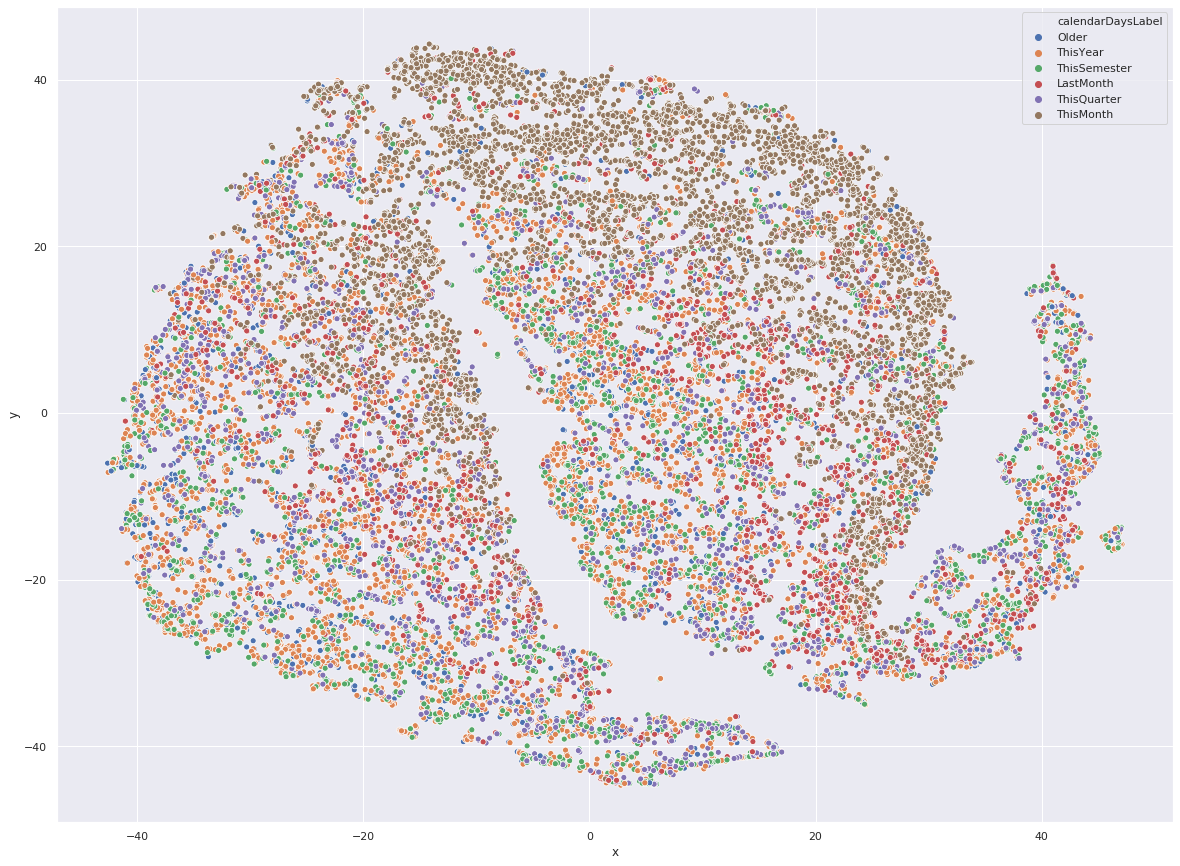

In [39]:
plt.figure(figsize=(20,15))

# Color the points by Army Branch
sns.scatterplot(x="x", y="y", hue='calendarDaysLabel', data=df1)

# Show the plot
plt.show()

In [40]:
df.drop(['x', 'y'], axis=1)

uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
userId                                                                   
1            0.0          0.0                  0.0                12.0   
2            3.0          0.0                  0.0                 0.0   
8            0.0          0.0                  0.0                 1.0   
9            0.0          0.0                  0.0                 0.0   
15           0.0          0.0                  0.0                 4.0   
...          ...          ...                  ...                 ...   
267789       5.0          0.0                  0.0                 0.0   
267834       1.0          0.0                  0.0                 0.0   
267841       0.0          0.0                  0.0                 0.0   
267856       0.0          0.0                  0.0                 0.0   
267866       3.0          0.0                  0.0                 0.0   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
userId                                                                        
1             0.0                 46.0          0.0                     0.0   
2             0.0                  5.0          2.0                     0.0   
8             0.0                 10.0          0.0                     0.0   
9             0.0                 38.0          0.0                     7.0   
15            0.0                 35.0          0.0                     0.0   
...           ...                  ...          ...                     ...   
267789        0.0                  8.0          1.0                     0.0   
267834        0.0                  4.0          1.0                     0.0   
267841        0.0                  3.0          1.0                     0.0   
267856        0.0                 10.0          1.0                     0.0   
267866        0.0                  6.0          1.0                     0.0   

        OpenedDonationModalFromCard  SawAdBeforeDonate  ...  \
userId                                                  ...   
1                             104.0              249.0  ...   
2                              16.0               44.0  ...   
8                               9.0               25.0  ...   
9                              34.0               81.0  ...   
15                             11.0               29.0  ...   
...                             ...                ...  ...   
267789                         16.0               42.0  ...   
267834                         11.0               22.0  ...   
267841                         14.0               39.0  ...   
267856                         11.0               33.0  ...   
267866                         15.0               35.0  ...   

        PromotionsClickedActiveIcon  PromotionsClickedCTA  \
userId                                                      
1                               1.0                   0.0   
2                               1.0                   0.0   
8                               2.0                   0.0   
9                               7.0                   5.0   
15                              9.0                   2.0   
...                             ...                   ...   
267789                          0.0                   0.0   
267834                          0.0                   0.0   
267841                          0.0                   0.0   
267856                          0.0                   0.0   
267866                          0.0                   0.0   

        PromotionsClickedInactiveIcon  PromotionsSawEmptyScreen  \
userId                                                            
1                                 0.0                       0.0   
2                                 0.0                       0.0   
8                                 0.0                       0.0   
9                                 2.0                       0.0   
1

In [41]:
from sklearn.feature_selection import VarianceThreshold

df_normalized = df.drop(['x', 'y'], axis=1) / df.drop(['x', 'y'], axis=1).mean()

In [42]:
# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=1)

# Fit the selector to normalized head_df
sel.fit(df_normalized)

df_normalized.shape[1], sel.get_support().sum()

(107, 105)

In [43]:
sel.get_support().sum()

105

In [44]:
df_normalized.Doou.describe()

count    22281.000000
mean         1.000000
std          1.429428
min          0.056526
25%          0.254367
50%          0.508735
75%          1.187048
max         58.645813
Name: Doou, dtype: float64

In [45]:
[c for c, b in zip(df_normalized.columns, sel.get_support()) if not b]

['ClickedCollectFeed', 'ReceiveBadgeClose']

In [46]:
# Create the correlation matrix
corr = abs(df_normalized.corr())

corr.describe()

uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
count  107.000000   107.000000           107.000000          107.000000   
mean     0.076061     0.024676             0.044208            0.105203   
std      0.109270     0.099096             0.103104            0.145319   
min      0.000950     0.000180             0.000474            0.000060   
25%      0.020184     0.001880             0.007033            0.019975   
50%      0.059294     0.004967             0.021162            0.057516   
75%      0.094701     0.018865             0.043724            0.120897   
max      1.000000     1.000000             1.000000            1.000000   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
count  107.000000           107.000000   107.000000              107.000000   
mean     0.022616             0.164965     0.113343                0.046964   
std      0.102714             0.181842     0.196098                0.107184   
min      0.000104             0.000427     0.001361                0.000185   
25%      0.001753             0.032206     0.023147                0.006509   
50%      0.003596             0.111049     0.046368                0.017055   
75%      0.007122             0.227077     0.092388                0.049432   
max      1.000000             1.000000     1.000000                1.000000   

       OpenedDonationModalFromCard  SawAdBeforeDonate  ...  \
count                   107.000000         107.000000  ...   
mean                      0.152546           0.154313  ...   
std                       0.203126           0.203235  ...   
min                       0.000459           0.001112  ...   
25%                       0.032087           0.031011  ...   
50%                       0.080883           0.087930  ...   
75%                       0.177437           0.183204  ...   
max                       1.000000           1.000000  ...   

       PromotionsClickedActiveIcon  PromotionsClickedCTA  \
count                   107.000000            107.000000   
mean                      0.130007              0.102427   
std                       0.152915              0.136006   
min                       0.000496              0.000104   
25%                       0.023862              0.016621   
50%                       0.085424              0.068435   
75%                       0.191637              0.142511   
max                       1.000000              1.000000   

       PromotionsClickedInactiveIcon  PromotionsSawEmptyScreen  \
count                     107.000000                107.000000   
mean                        0.093372                  0.053279   
std                         0.130568                  0.122384   
min                         0.001053                  0.000641   
25%                         0.015599                  0.006757   
50%                         0.057418                  0.021957   
75%                         0.128010                  0.044261   
max                         1.000000                  1.000000   

       PromotionsClickedSocial  PromotionsSawPromoCard  \
count               107.000000              107.000000   
mean                  0.028165                0.084161   
std                   0.103445                0.128324   
min                   0.000031                0.000681   
25%                   0.001834                0.015144   
50%                   0.006325                0.053134   
75%                   0.020025                0.104921   
max                   1.000000                1.000000   

       DonationSawSubscriptionPackage  ImpactSawCommunityImpact  \
count                      107.000000                107.000000   
mean                         0.095883                  0.029722   
std                          0.119190                  0.098408   
min                          0.001253                  0.000135   
25%                          0.021274                  0.002540   
5

In [47]:
[e for e, v in ((corr > 0.95).sum() >1).items() if v]

['OpenedDonationModalFromCard',
 'SawAdBeforeDonate',
 'Doou',
 'SkippedTutorialFromOnBoarding',
 'OnboardingClickedSignup']

In [48]:
[e for e, v in ((corr > 0.95).sum() >2).items() if v]

['OpenedDonationModalFromCard', 'SawAdBeforeDonate', 'Doou']

In [49]:
# filtrar as colunas de eventos com baixa variancia e com extremo correlacionamento com o eveno de doação
columnsFiltered = ['ClickedCollectFeed', 'ReceiveBadgeClose', 'OpenedDonationModalFromCard', 'SawAdBeforeDonate'] +\
                  ['x', 'y']

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the scaler and standardize the data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df.drop(columnsFiltered, axis=1))

In [51]:
df_normalized.shape

(22281, 103)

In [52]:
# Create the PCA instance and fit and transform the data with pca
pca = PCA()
pca.fit(df_normalized)

# This changes the numpy array output back to a dataframe
#pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4'])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [53]:
col = (pca.explained_variance_ratio_.cumsum() <= 0.7).sum()
col

38

In [54]:
pc = pca.fit_transform(df_normalized)

In [55]:
for i in range(col):
    c = 'PCA{}'.format(i)
    df1[c] = pc[:,i]

In [56]:
[c for c in df1.columns if 'PCA' not in c]

['userId',
 'deviceModel',
 'countryISO',
 'firstAccess',
 'lastAccess',
 'cohort',
 'donationLast90days',
 'lastDayAccess',
 'lastDayLabel',
 'donationLast90Label',
 'calendarDays',
 'activeDaysTWT',
 'averageActiveDaysTWT',
 'halfLifeActivityDaysTWT',
 'donationTWT',
 'halfLifeDonationTWT',
 'activeDaysAP',
 'donationAP',
 'averageDonationActiveDayAP',
 'averageDonationAP',
 'averageDaysBetweenDonationEvents',
 'daysSinceLastDonations',
 'calendarDaysLabel',
 'donationAPLabel',
 'x',
 'y']

In [57]:
colFilter = ['userId', 'deviceModel',  'countryISO', 'firstAccess', 'lastAccess', 'cohort', 'lastDayLabel', 
             'donationLast90Label', 'calendarDaysLabel', 'donationAPLabel', 'x', 'y']

In [58]:
df1.drop(colFilter, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22281 entries, 0 to 22280
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   donationLast90days                22281 non-null  float64
 1   lastDayAccess                     22281 non-null  int64  
 2   calendarDays                      22281 non-null  int64  
 3   activeDaysTWT                     22281 non-null  int64  
 4   averageActiveDaysTWT              22281 non-null  float64
 5   halfLifeActivityDaysTWT           22281 non-null  int64  
 6   donationTWT                       22281 non-null  float64
 7   halfLifeDonationTWT               22281 non-null  int64  
 8   activeDaysAP                      22281 non-null  int64  
 9   donationAP                        22281 non-null  float64
 10  averageDonationActiveDayAP        22281 non-null  float64
 11  averageDonationAP                 22281 non-null  float64
 12  aver

In [59]:
samples = np.array(df1.drop(colFilter, axis=1))
samples.shape

(22281, 52)

In [78]:
features = [c for c in df1.columns if c not in colFilter]
features 

['donationLast90days',
 'lastDayAccess',
 'calendarDays',
 'activeDaysTWT',
 'averageActiveDaysTWT',
 'halfLifeActivityDaysTWT',
 'donationTWT',
 'halfLifeDonationTWT',
 'activeDaysAP',
 'donationAP',
 'averageDonationActiveDayAP',
 'averageDonationAP',
 'averageDaysBetweenDonationEvents',
 'daysSinceLastDonations',
 'PCA0',
 'PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10',
 'PCA11',
 'PCA12',
 'PCA13',
 'PCA14',
 'PCA15',
 'PCA16',
 'PCA17',
 'PCA18',
 'PCA19',
 'PCA20',
 'PCA21',
 'PCA22',
 'PCA23',
 'PCA24',
 'PCA25',
 'PCA26',
 'PCA27',
 'PCA28',
 'PCA29',
 'PCA30',
 'PCA31',
 'PCA32',
 'PCA33',
 'PCA34',
 'PCA35',
 'PCA36',
 'PCA37']

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

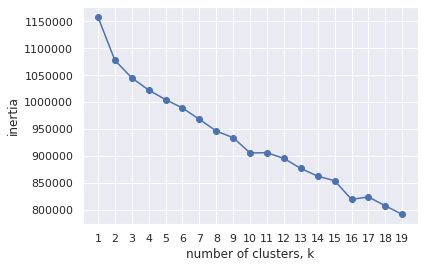

CPU times: user 2min 16s, sys: 1.83 s, total: 2min 17s
Wall time: 43.7 s


In [195]:
%%time

ks = range(1, 20)
inertias = []

for k in ks:
    # Create scaler: scaler
    scaler = StandardScaler()
    
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    
    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, kmeans)
    
    # Fit the pipeline to samples
    pipeline.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.15199997922330805
For n_clusters = 3 The average silhouette_score is : 0.08958890306350363
For n_clusters = 4 The average silhouette_score is : 0.10130231144431286
For n_clusters = 5 The average silhouette_score is : 0.1030771607916923
For n_clusters = 6 The average silhouette_score is : 0.06953288095276018
For n_clusters = 7 The average silhouette_score is : 0.062443136340431325
For n_clusters = 8 The average silhouette_score is : 0.06984073894133103
For n_clusters = 9 The average silhouette_score is : 0.07010542851171875
For n_clusters = 10 The average silhouette_score is : 0.07075658131803303
For n_clusters = 11 The average silhouette_score is : 0.07035117219145966
For n_clusters = 12 The average silhouette_score is : 0.06793346455627473
For n_clusters = 13 The average silhouette_score is : 0.05674147977404454
For n_clusters = 14 The average silhouette_score is : 0

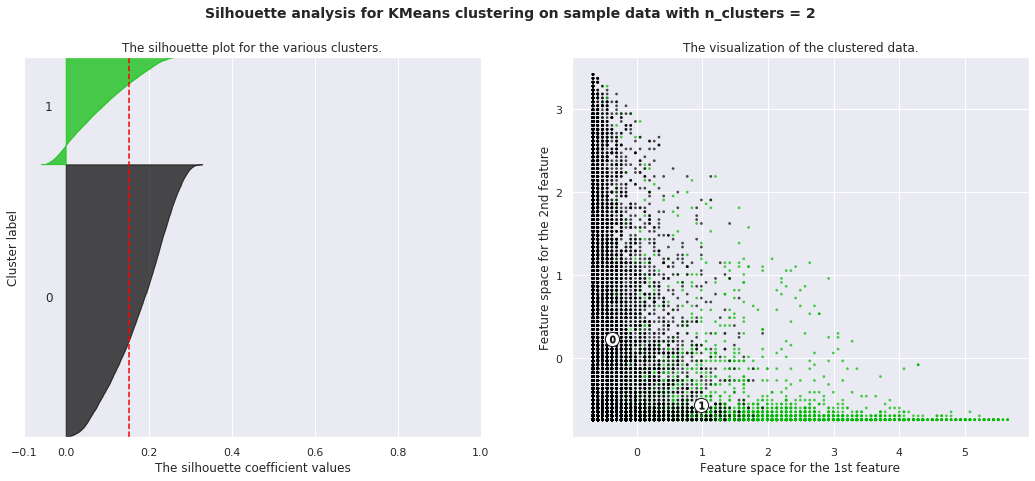

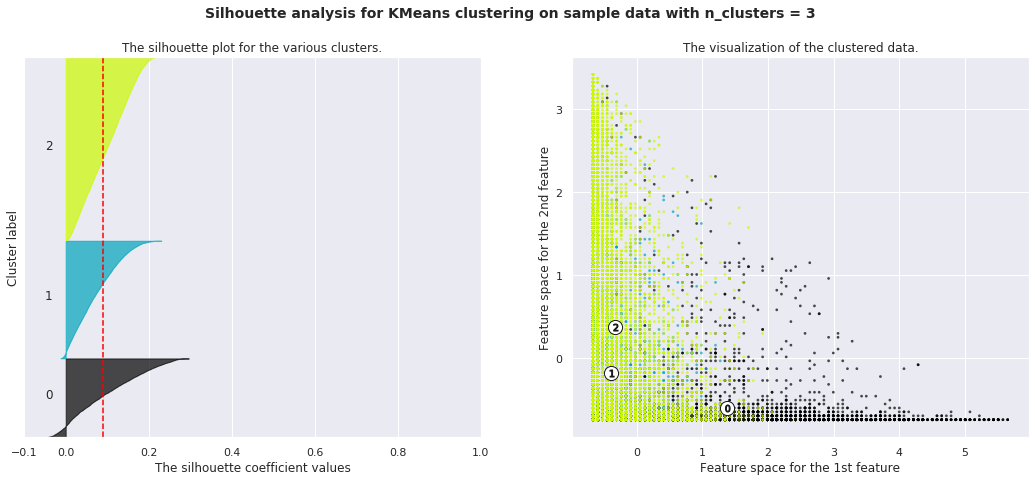

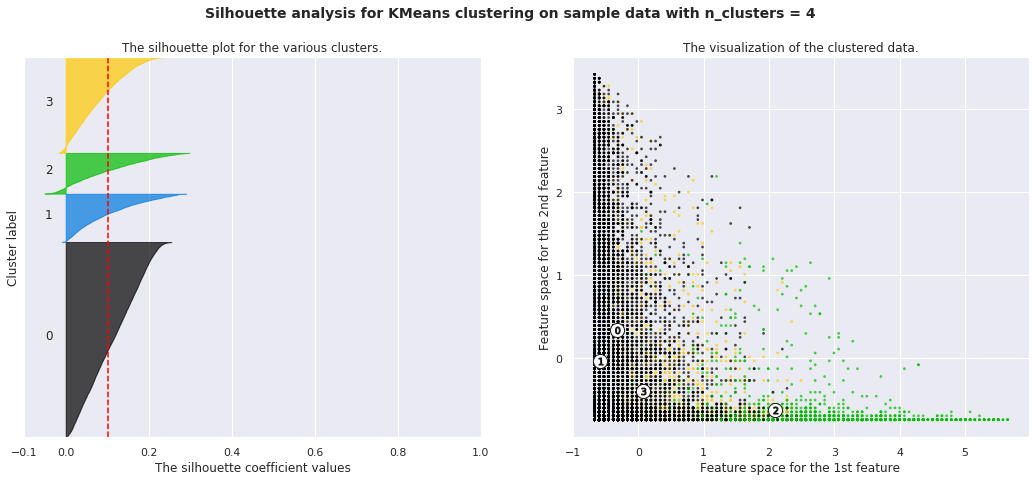

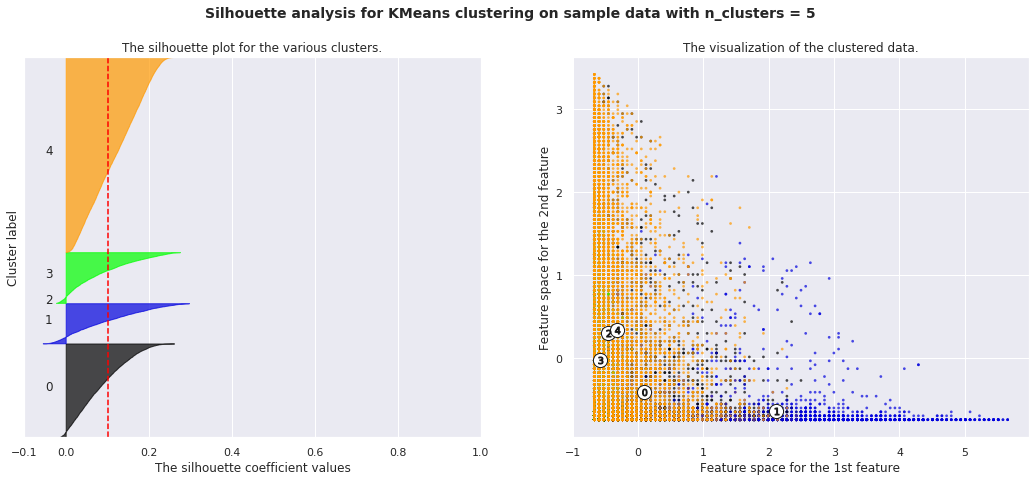

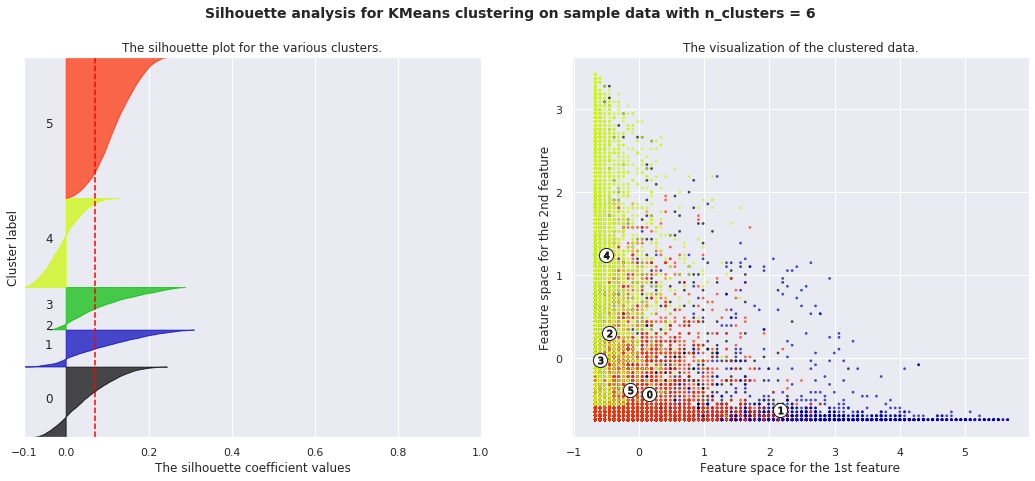

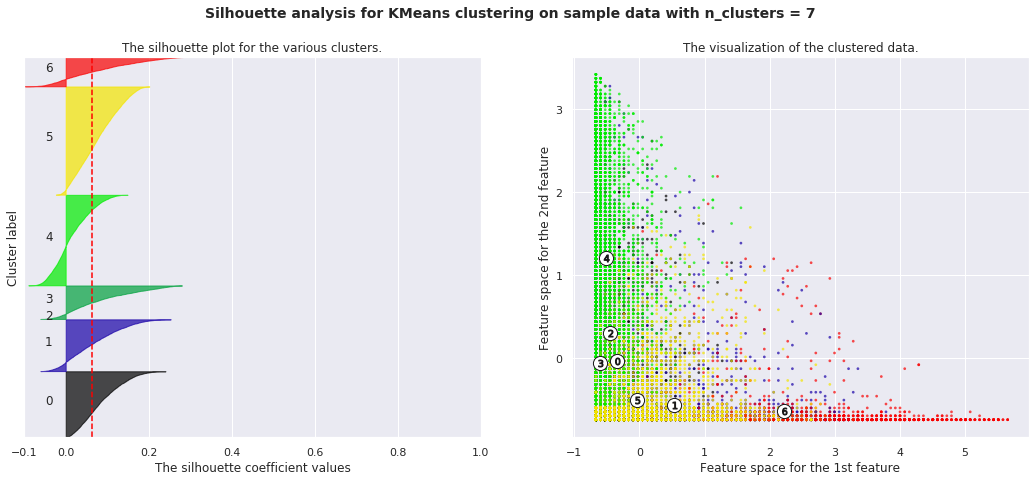

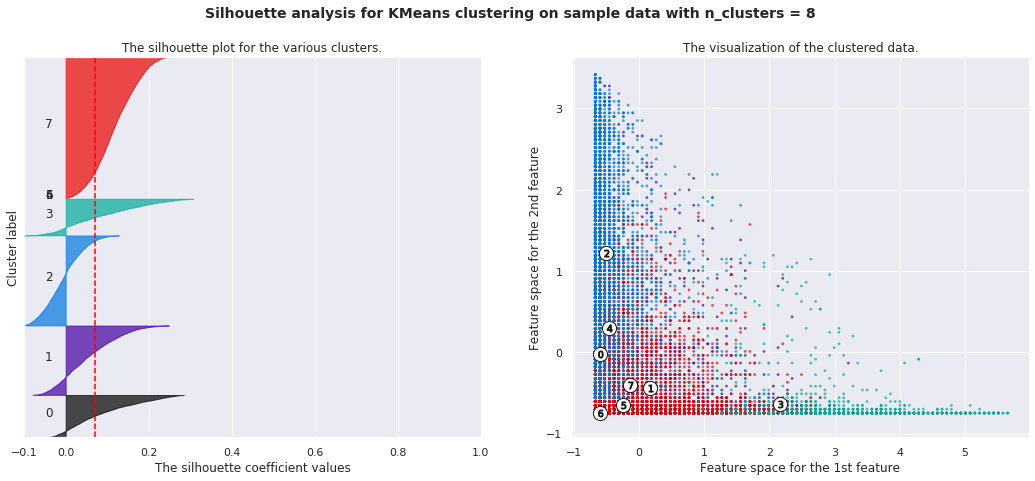

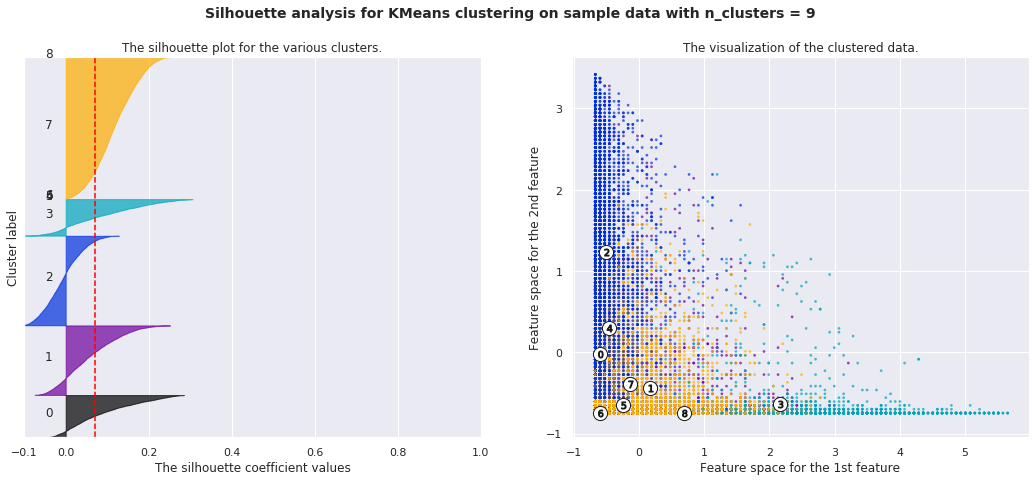

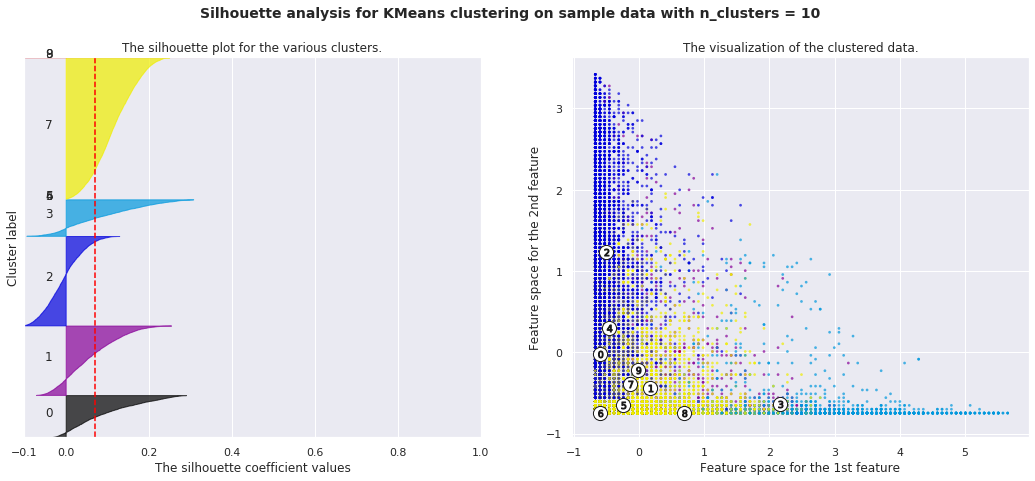

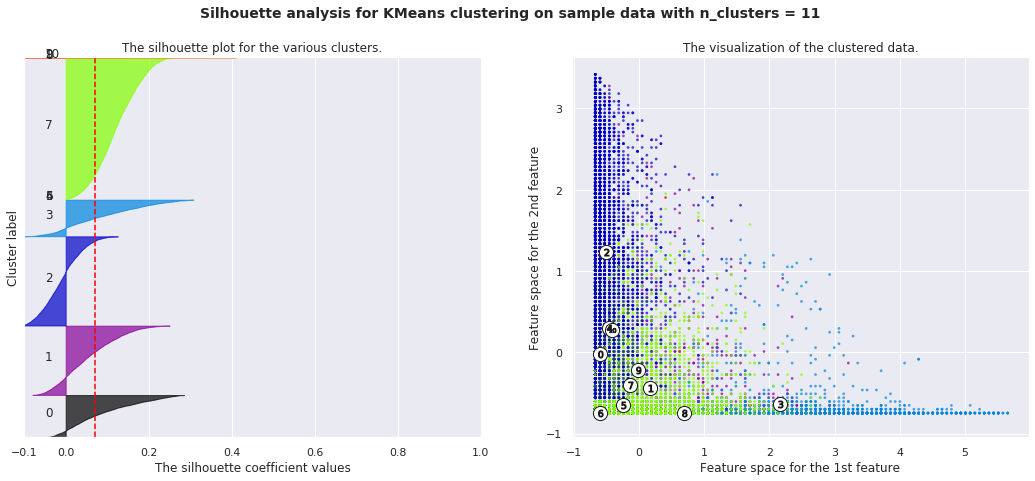

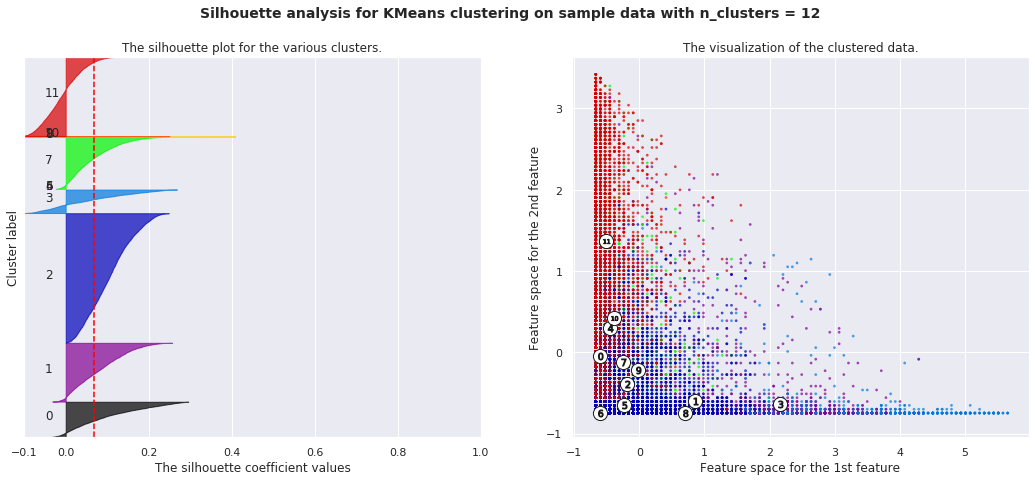

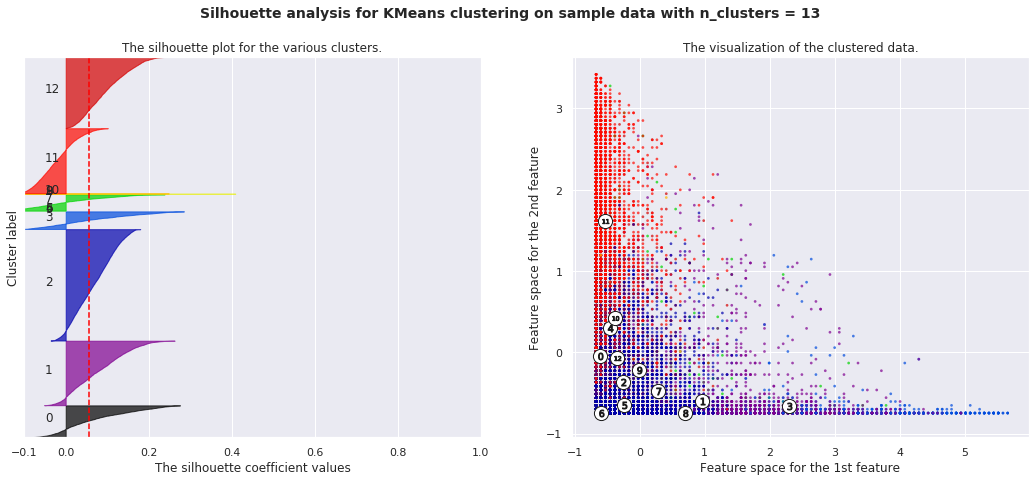

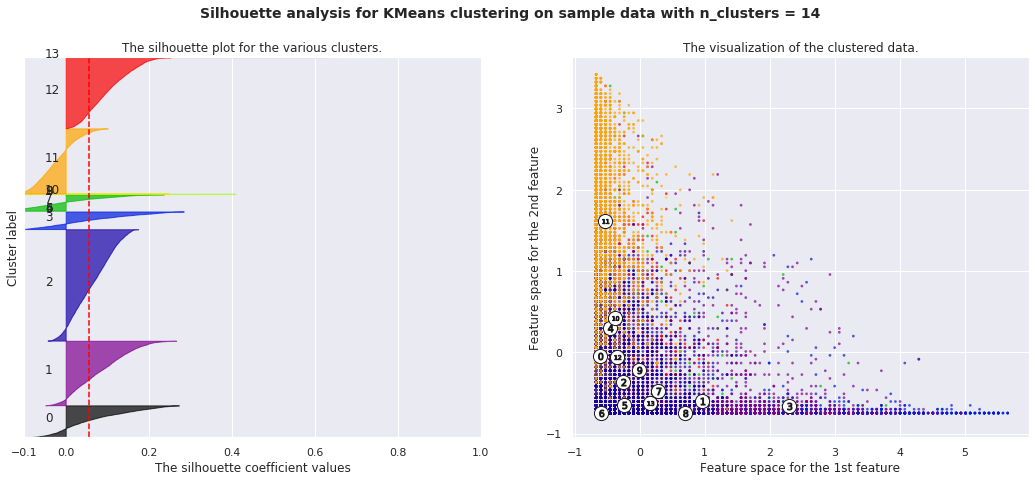

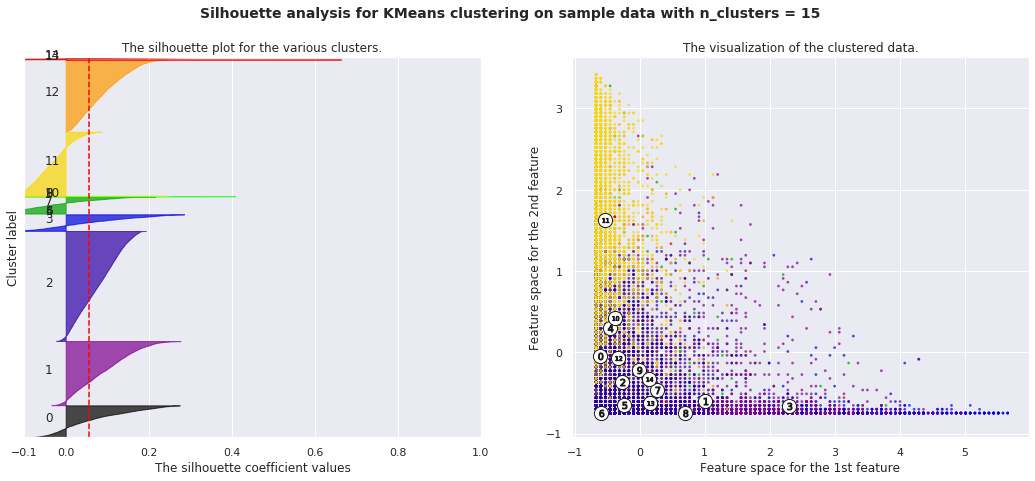

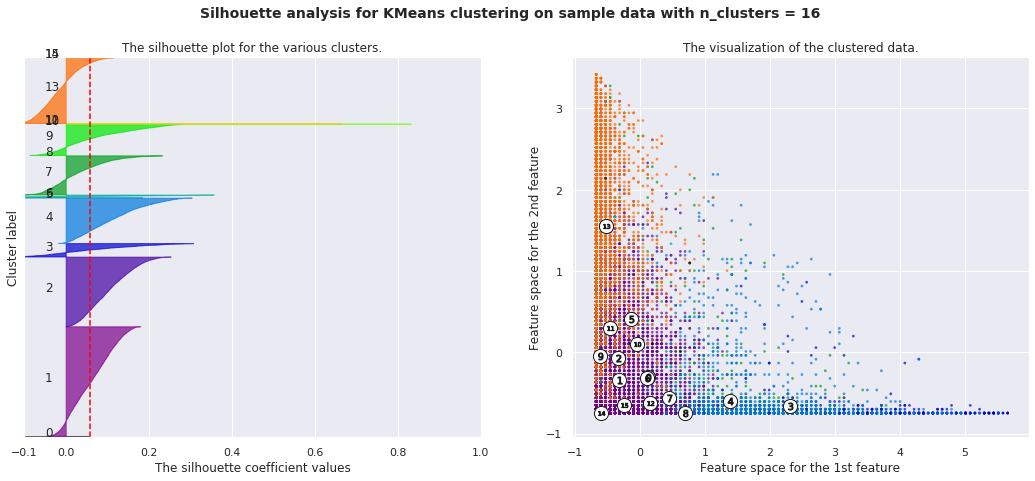

CPU times: user 6min 32s, sys: 57.7 s, total: 7min 30s
Wall time: 3min 27s


In [203]:
%%time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
scaler = StandardScaler()
X = scaler.fit_transform(samples)

range_n_clusters = range(2,17)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [61]:
#########################
#### depois usar
#########################
nc = 5
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=nc)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(samples)

# Calculate the cluster labels: labels
labels = pipeline.predict(samples)

#l = pd.DataFrame(labels).groupby(0).size()
l = pd.DataFrame(labels)
pd.concat([l.groupby(0).size(), l.groupby(0).size().agg(lambda x: x / len(l))], axis=1)

0         1
0                
0  4137  0.185674
1  5214  0.234011
2  2170  0.097392
3  8290  0.372066
4  2470  0.110857

In [62]:
len(labels), df1.shape

(22281, (22281, 64))

In [63]:
y = labels
X = samples

# Split data into 80% train and 20% test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [64]:
# Define the dictionary 'params_rf'
params_rf = {
    'n_estimators': [100, 300, 500, 1000],
    'max_features': ['log2', 'auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [5, 10, 15, 30],
    'criterion' :['gini', 'entropy']
}

In [213]:
# # Define the dictionary 'params_rf'
# params_rf = {
#     'n_estimators': [100, 300, 500, 800, 1200],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_split': [2, 5, 10, 15, 100],
#     'max_depth': [5, 8, 15, 25, 30],
# }

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [66]:
%%time

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='f1_weighted',
                       cv=5,
                       verbose=1,
                       n_jobs=10)

CPU times: user 84 µs, sys: 1 µs, total: 85 µs
Wall time: 92.3 µs


In [67]:
%%time
#grid_rf.fit(X_train, y_train)
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 26.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 58.1min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 110.3min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 218.5min
[Parallel(n_jobs=10)]: Done 1920 out of 1920 | elapsed: 251.0min finished


CPU times: user 1min 36s, sys: 712 ms, total: 1min 36s
Wall time: 4h 12min 29s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [68]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [69]:
clf = RandomForestClassifier(criterion = 'gini', n_estimators=1000, max_depth=30,
                             max_features= 'auto', min_samples_leaf= 1)

In [70]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
y_pred = clf.predict(X_test)

In [72]:
# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [73]:
f1_score(y_test, y_pred, average='weighted')

0.9434653832356246

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       851
           1       0.94      0.94      0.94      1063
           2       0.97      0.96      0.97       432
           3       0.93      0.95      0.94      1641
           4       0.95      0.92      0.93       470

    accuracy                           0.94      4457
   macro avg       0.95      0.94      0.95      4457
weighted avg       0.94      0.94      0.94      4457



In [74]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))

[[ 807    4    8   24    8]
 [   0  994    0   62    7]
 [   9    1  416    6    0]
 [  21   52    4 1554   10]
 [  10    5    1   20  434]]


In [76]:
clf.feature_importances_

array([0.0416704 , 0.10298466, 0.06132751, 0.0754706 , 0.02235146,
       0.08238601, 0.02915075, 0.04119866, 0.04499713, 0.039348  ,
       0.01891198, 0.04302576, 0.07415916, 0.0772172 , 0.00734175,
       0.03363476, 0.05291443, 0.01366033, 0.004452  , 0.00660839,
       0.00442217, 0.0037671 , 0.00955917, 0.00387816, 0.0040597 ,
       0.00449159, 0.00372095, 0.00350971, 0.00365528, 0.00357199,
       0.00356497, 0.00368499, 0.00371866, 0.00358428, 0.00407414,
       0.00386797, 0.00365342, 0.00351989, 0.00377622, 0.00393734,
       0.0036192 , 0.00347505, 0.00351174, 0.00327189, 0.00448879,
       0.00340897, 0.00386423, 0.00374853, 0.00347237, 0.00352035,
       0.00506437, 0.00372586])

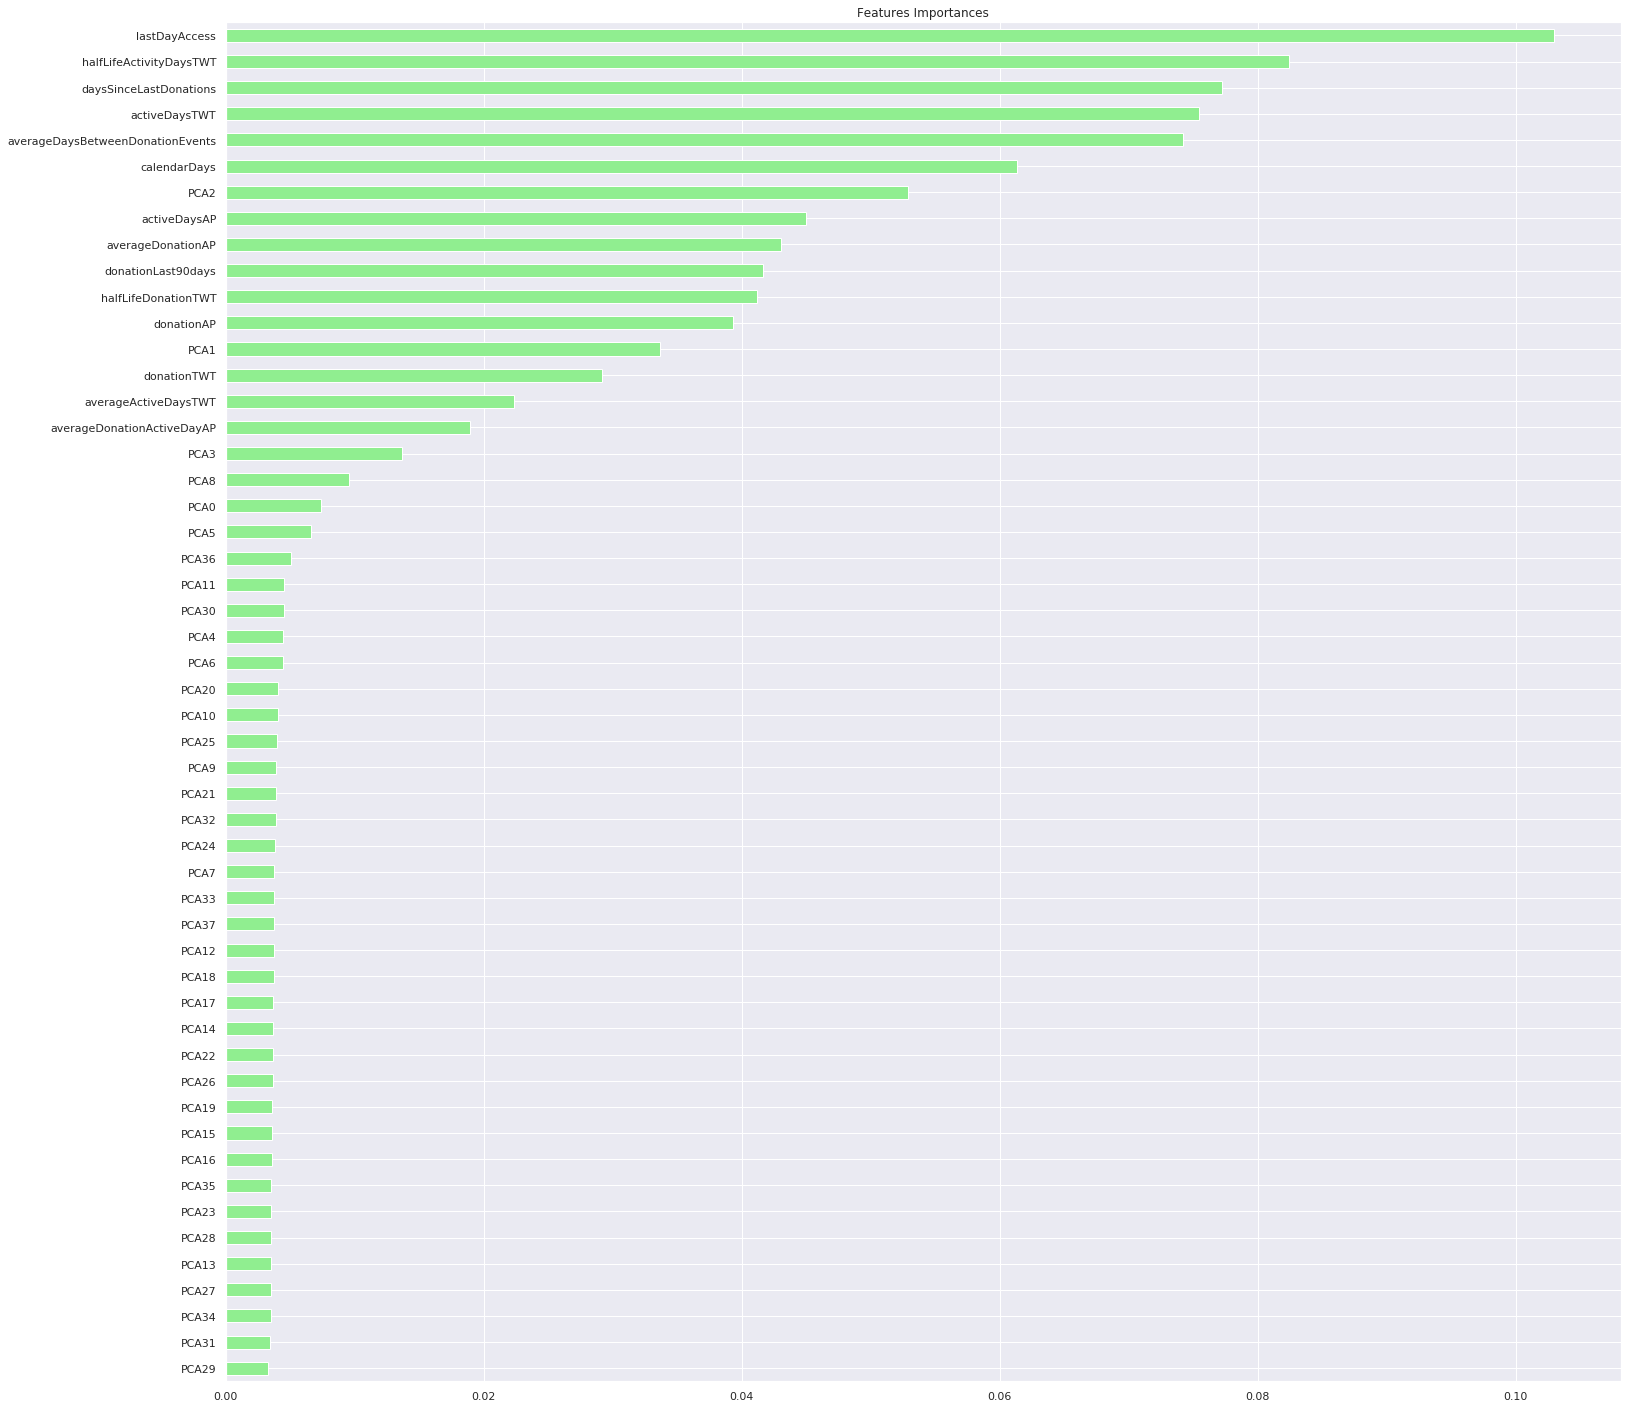

In [79]:
_ = plt.figure(figsize=[25,25])

# Create a pd.Series of features importances
importances = pd.Series(data=clf.feature_importances_,
                        index= features)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [80]:
importances_sorted.sort_values(ascending=False)[:52]

lastDayAccess                       0.102985
halfLifeActivityDaysTWT             0.082386
daysSinceLastDonations              0.077217
activeDaysTWT                       0.075471
averageDaysBetweenDonationEvents    0.074159
calendarDays                        0.061328
PCA2                                0.052914
activeDaysAP                        0.044997
averageDonationAP                   0.043026
donationLast90days                  0.041670
halfLifeDonationTWT                 0.041199
donationAP                          0.039348
PCA1                                0.033635
donationTWT                         0.029151
averageActiveDaysTWT                0.022351
averageDonationActiveDayAP          0.018912
PCA3                                0.013660
PCA8                                0.009559
PCA0                                0.007342
PCA5                                0.006608
PCA36                               0.005064
PCA11                               0.004492
PCA30     

In [82]:
df1[features]

donationLast90days  lastDayAccess  calendarDays  activeDaysTWT  \
0                    14.0              1           891             74   
1                     4.0              1           918             80   
2                    12.0              1           925            391   
3                    17.0              2           911            182   
4                    15.0              1           918            382   
...                   ...            ...           ...            ...   
22276                 2.0             57             2              2   
22277                 2.0             57             2              2   
22278                 2.0             57             2              2   
22279                 2.0             57             2              2   
22280                 2.0             57             2              2   

       averageActiveDaysTWT  halfLifeActivityDaysTWT  donationTWT  \
0                  0.083053                      766        163.0   
1                  0.087146                      294         91.0   
2                  0.422703                      364        302.0   
3                  0.199780                      570        144.0   
4                  0.416122                      630        365.0   
...                     ...                      ...          ...   
22276              1.000000                        1          7.0   
22277              1.000000                        1         10.0   
22278              1.000000                        1          4.0   
22279              1.000000                        1          7.0   
22280              1.000000                        1          6.0   

       halfLifeDonationTWT  activeDaysAP  donationAP  ...     PCA28     PCA29  \
0                      823            27        98.0  ...  2.018247  1.228327   
1                      163             6         9.0  ... -0.758635  0.110797   
2                      429            31        26.0  ... -0.932437 -0.167105   
3                      559            30        20.0  ...  0.508842 -1.458621   
4                      529            66        22.0  ...  0.155700 -0.622721   
...                    ...           ...         ...  ...       ...       ...   
22276                    2             2         7.0  ...  0.766375  1.343877   
22277                    1             2        10.0  ... -0.703678  3.144469   
22278                    1             2         4.0  ...  0.687502  0.333685   
22279                    2             2         7.0  ...  0.782777  0.902944   
22280                    1             2         6.0  ...  0.930358  3.025274   

          PCA30     PCA31     PCA32     PCA33     PCA34     PCA35     PCA36  \
0      0.032467 -1.239289 -0.035120 -0.130936  0.022135 -0.488846 -0.921860   
1     -0.168063  0.654070 -0.005150 -0.180201  0.224100 -0.474995  0.168045   
2      0.152168 -0.011757 -0.212596 -0.059759 -0.423738  0.511716  0.679559   
3      1.234099  1.732731 -1.327515  0.655798  1.134685  3.280478  0.545711   
4      0.912313  0.445742 -1.322226  0.413995 -1.227948  0.242688  0.927096   
...         ...       ...       ...       ...       ...       ...       ...   
22276 -0.485298  0.131114  0.161477 -0.641304  0.676645  0.217113  0.358482   
22277 -2.073398 -4.352452  0.153319  0.327242 -4.555550 -1.567607  0.001404   
22278  0.292986 -0.259428 -0.330458 -0.232215  0.317490  1.147909 -1.825875   
22279 -0.719432 -0.748645  0.537850 -0.182095  0.392308  0.392546  0.219325   
22280 -0.434985 -1.461610  0.521763 -1.819677 -0.306800 -0.009904 -0.164693   

          PCA37  
0      0.804947  
1     -1.766503  
2      0.112436  
3      1.548644  
4     -1.097352  
...         ...  
22276 -2.266285  
22277 -0.700686  
22278  2.199153  
22279  0.583217  
22280 -1.593582  

[22281 rows x 52 columns]

In [90]:
users.describe().

userId  donationLast90days  lastDayAccess  calendarDays  \
count   22281.000000        22281.000000   22281.000000  22281.000000   
mean   179279.227728           11.321530      15.773484    180.772631   
std     76844.795477           13.912229      21.127116    164.238781   
min         1.000000            2.000000       0.000000      2.000000   
25%    128218.000000            3.000000       0.000000     38.000000   
50%    205874.000000            6.000000       4.000000    138.000000   
75%    244158.000000           13.000000      25.000000    306.000000   
max    267866.000000           90.000000      88.000000    925.000000   

       activeDaysTWT  averageActiveDaysTWT  halfLifeActivityDaysTWT  \
count   22281.000000          22281.000000             22281.000000   
mean       68.488533              0.417770                79.222611   
std        85.229088              0.270318                89.436246   
min         2.000000              0.008547                 1.000000   
25%         8.000000              0.181818                12.000000   
50%        32.000000              0.375000                54.000000   
75%        99.000000              0.625000               115.000000   
max       724.000000              1.000000               779.000000   

        donationTWT  halfLifeDonationTWT  activeDaysAP    donationAP  \
count  22281.000000         22281.000000  22281.000000  22281.000000   
mean      97.296037            77.003591     22.278399     35.381895   
std      134.999252            89.354376     22.675308     50.575854   
min        2.000000             1.000000      2.000000      2.000000   
25%       17.000000            11.000000      5.000000      9.000000   
50%       47.000000            50.000000     12.000000     18.000000   
75%      121.000000           110.000000     35.000000     42.000000   
max     2142.000000           877.000000     90.000000   2075.000000   

       averageDonationActiveDayAP  averageDonationAP  \
count                22281.000000       22281.000000   
mean                     2.355371           0.393132   
std                      2.348698           0.561954   
min                      0.025000           0.022222   
25%                      0.833333           0.100000   
50%                      1.641509           0.200000   
75%                      3.125000           0.466667   
max                     61.000000          23.055556   

       averageDaysBetweenDonationEvents  daysSinceLastDonations  
count                      22281.000000            22281.000000  
mean                           9.128594               10.560029  
std                           10.795093               12.730750  
min                            1.000000                1.000000  
25%                            2.500000                2.000000  
50%                            5.250000                6.000000  
75%                           11.400000               14.000000  
max                           88.000000               88.000000

In [91]:
usersNumericColumns = ['donationLast90days', 'lastDayAccess', 'calendarDays', 'activeDaysTWT',
                       'averageActiveDaysTWT', 'halfLifeActivityDaysTWT', 'donationTWT',
                       'halfLifeDonationTWT', 'activeDaysAP', 'donationAP', 'averageDonationActiveDayAP',
                       'averageDonationAP', 'averageDaysBetweenDonationEvents', 'daysSinceLastDonations']

In [114]:
df.drop(columnsFiltered, axis=1)

uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
userId                                                                   
1            0.0          0.0                  0.0                12.0   
2            3.0          0.0                  0.0                 0.0   
8            0.0          0.0                  0.0                 1.0   
9            0.0          0.0                  0.0                 0.0   
15           0.0          0.0                  0.0                 4.0   
...          ...          ...                  ...                 ...   
267789       5.0          0.0                  0.0                 0.0   
267834       1.0          0.0                  0.0                 0.0   
267841       0.0          0.0                  0.0                 0.0   
267856       0.0          0.0                  0.0                 0.0   
267866       3.0          0.0                  0.0                 0.0   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
userId                                                                        
1             0.0                 46.0          0.0                     0.0   
2             0.0                  5.0          2.0                     0.0   
8             0.0                 10.0          0.0                     0.0   
9             0.0                 38.0          0.0                     7.0   
15            0.0                 35.0          0.0                     0.0   
...           ...                  ...          ...                     ...   
267789        0.0                  8.0          1.0                     0.0   
267834        0.0                  4.0          1.0                     0.0   
267841        0.0                  3.0          1.0                     0.0   
267856        0.0                 10.0          1.0                     0.0   
267866        0.0                  6.0          1.0                     0.0   

        OpenedAdOnFeed  OpenedFeedFullText  ...  PromotionsClickedActiveIcon  \
userId                                      ...                                
1                  0.0                 1.0  ...                          1.0   
2                  0.0                 2.0  ...                          1.0   
8                  0.0                 0.0  ...                          2.0   
9                  3.0                 0.0  ...                          7.0   
15                 0.0                 0.0  ...                          9.0   
...                ...                 ...  ...                          ...   
267789             2.0                 2.0  ...                          0.0   
267834             4.0                 0.0  ...                          0.0   
267841             0.0                 1.0  ...                          0.0   
267856             0.0                 1.0  ...                          0.0   
267866             2.0                 0.0  ...                          0.0   

        PromotionsClickedCTA  PromotionsClickedInactiveIcon  \
userId                                                        
1                        0.0                            0.0   
2                        0.0                            0.0   
8                        0.0                            0.0   
9                        5.0                            2.0   
15                       2.0                            1.0   
...                      ...                            ...   
267789                   0.0                            0.0   
267834                   0.0                            0.0   
267841                   0.0                            0.0   
267856                   0.0                            0.0   
267866                   0.0                            0.0   

        PromotionsSawEmptyScreen  PromotionsClickedSocial  \
userId                                                      
1                            0.0  

In [115]:
X = df.drop(columnsFiltered, axis=1)
X

uncaught  openNgoInfo  openFaqFromSettings  OpenedNotification  \
userId                                                                   
1            0.0          0.0                  0.0                12.0   
2            3.0          0.0                  0.0                 0.0   
8            0.0          0.0                  0.0                 1.0   
9            0.0          0.0                  0.0                 0.0   
15           0.0          0.0                  0.0                 4.0   
...          ...          ...                  ...                 ...   
267789       5.0          0.0                  0.0                 0.0   
267834       1.0          0.0                  0.0                 0.0   
267841       0.0          0.0                  0.0                 0.0   
267856       0.0          0.0                  0.0                 0.0   
267866       3.0          0.0                  0.0                 0.0   

        OpenedApp  SendOneSignalUserId  FirstOpened  openNgoProfileFromCard  \
userId                                                                        
1             0.0                 46.0          0.0                     0.0   
2             0.0                  5.0          2.0                     0.0   
8             0.0                 10.0          0.0                     0.0   
9             0.0                 38.0          0.0                     7.0   
15            0.0                 35.0          0.0                     0.0   
...           ...                  ...          ...                     ...   
267789        0.0                  8.0          1.0                     0.0   
267834        0.0                  4.0          1.0                     0.0   
267841        0.0                  3.0          1.0                     0.0   
267856        0.0                 10.0          1.0                     0.0   
267866        0.0                  6.0          1.0                     0.0   

        OpenedAdOnFeed  OpenedFeedFullText  ...  PromotionsClickedActiveIcon  \
userId                                      ...                                
1                  0.0                 1.0  ...                          1.0   
2                  0.0                 2.0  ...                          1.0   
8                  0.0                 0.0  ...                          2.0   
9                  3.0                 0.0  ...                          7.0   
15                 0.0                 0.0  ...                          9.0   
...                ...                 ...  ...                          ...   
267789             2.0                 2.0  ...                          0.0   
267834             4.0                 0.0  ...                          0.0   
267841             0.0                 1.0  ...                          0.0   
267856             0.0                 1.0  ...                          0.0   
267866             2.0                 0.0  ...                          0.0   

        PromotionsClickedCTA  PromotionsClickedInactiveIcon  \
userId                                                        
1                        0.0                            0.0   
2                        0.0                            0.0   
8                        0.0                            0.0   
9                        5.0                            2.0   
15                       2.0                            1.0   
...                      ...                            ...   
267789                   0.0                            0.0   
267834                   0.0                            0.0   
267841                   0.0                            0.0   
267856                   0.0                            0.0   
267866                   0.0                            0.0   

        PromotionsSawEmptyScreen  PromotionsClickedSocial  \
userId                                                      
1                            0.0  

In [86]:
len(labels)

22281

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size= 0.2)

In [117]:
clf_RF = RandomForestClassifier(criterion = 'gini', n_estimators=1000, max_depth=30,
                                max_features= 'auto', min_samples_leaf= 1)

In [118]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [119]:
y_pred = clf_RF.predict(X_test)

In [120]:
f1_score(y_test, y_pred, average='weighted')

0.4083694719471122

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.06      0.10       849
           1       0.67      0.82      0.74      1048
           2       1.00      0.00      0.00       416
           3       0.45      0.83      0.58      1650
           4       0.00      0.00      0.00       494

    accuracy                           0.51      4457
   macro avg       0.50      0.34      0.28      4457
weighted avg       0.49      0.51      0.41      4457



In [122]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))

[[  49   52    0  748    0]
 [   2  857    0  188    1]
 [  18   44    1  353    0]
 [  50  235    0 1365    0]
 [  19   83    0  392    0]]


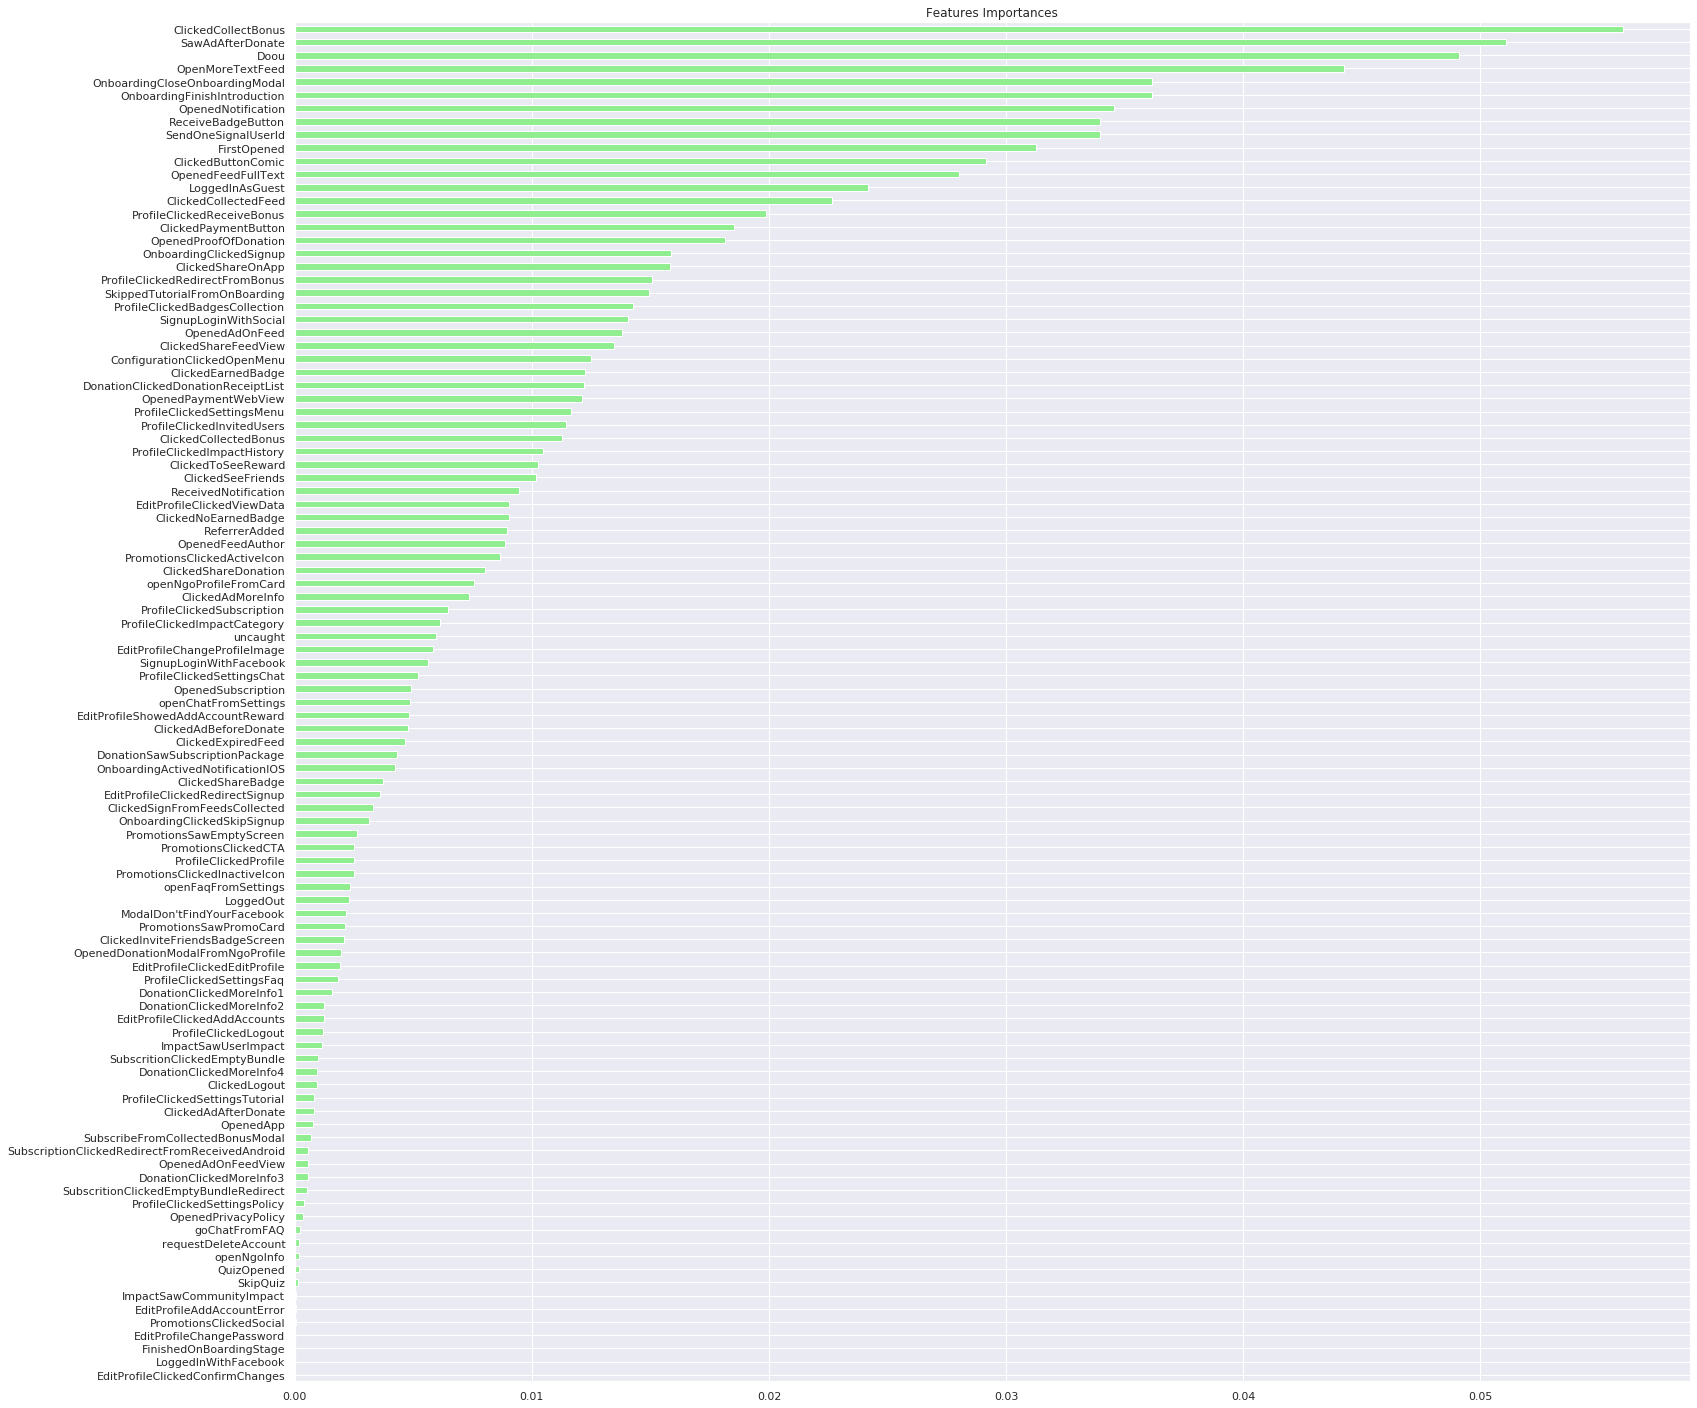

In [123]:
_ = plt.figure(figsize=[25,25])

# Create a pd.Series of features importances
importances = pd.Series(data=clf_RF.feature_importances_,
                        index= list(X.columns))

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [124]:
importances_sorted.sort_values(ascending=False)[:52]

ClickedCollectBonus                   0.056034
SawAdAfterDonate                      0.051078
Doou                                  0.049115
OpenMoreTextFeed                      0.044240
OnboardingCloseOnboardingModal        0.036163
OnboardingFinishIntroduction          0.036144
OpenedNotification                    0.034546
ReceiveBadgeButton                    0.033975
SendOneSignalUserId                   0.033974
FirstOpened                           0.031244
ClickedButtonComic                    0.029157
OpenedFeedFullText                    0.027996
LoggedInAsGuest                       0.024171
ClickedCollectedFeed                  0.022652
ProfileClickedReceiveBonus            0.019889
ClickedPaymentButton                  0.018514
OpenedProofOfDonation                 0.018125
OnboardingClickedSignup               0.015880
ClickedShareOnApp                     0.015809
ProfileClickedRedirectFromBonus       0.015072
SkippedTutorialFromOnBoarding         0.014948
ProfileClicke